IMPORT PACKAGES

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp
import wandb
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,jaccard_score
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from skimage.filters import threshold_otsu
from IPython.display import Image

In [ ]:
# Determine if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


LOAD IMAGES

In [ ]:
from PIL import Image

# Load and preprocess images and masks
def load_and_preprocess_images_and_masks(image_dir, mask_dir, target_size=(512, 512)):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))])

    images = []
    masks = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        # Load image
        image = Image.open(img_path).convert('RGB')
        image = image.resize(target_size)
        image = np.array(image).astype(np.float32) / 255.0

        # Load mask
        mask = Image.open(mask_path).convert('L')
        mask = mask.resize(target_size)
        mask = np.array(mask).astype(np.float32)
        mask = np.where(mask > 127, 1.0, 0.0)

        # Add the preprocessed image and mask to lists
        images.append(image)
        masks.append(mask)

    # Convert lists to numpy arrays
    images = np.stack(images, axis=0)
    masks = np.stack(masks, axis=0)

    return images, masks

# Function to create datasets for train, val, and test
def create_datasets(base_dir, target_size=(512, 512)):
    image_base_dir = os.path.join(base_dir, 'images')
    mask_base_dir = os.path.join(base_dir, 'masks')
    dataset_types = ['train', 'val', 'test']

    datasets = {}

    for dataset_type in dataset_types:
        image_dir = os.path.join(image_base_dir, dataset_type)
        mask_dir = os.path.join(mask_base_dir, dataset_type)

        # Load and preprocess images and masks
        images, masks = load_and_preprocess_images_and_masks(image_dir, mask_dir, target_size=target_size)

        datasets[f'X_{dataset_type}'] = images
        datasets[f'Y_{dataset_type}'] = masks

        print(f'{dataset_type.upper()} - Images Shape: {images.shape}, Masks Shape: {masks.shape}')
        print(f'{dataset_type.upper()} - Number of Images: {len(images)}, Number of Masks: {len(masks)}')

    return datasets

# Define the base directory
base_dir = '/content/drive/MyDrive/Lab 3'

# Create datasets
datasets = create_datasets(base_dir)

TRAIN - Images Shape: (10, 512, 512, 3), Masks Shape: (10, 512, 512)
TRAIN - Number of Images: 10, Number of Masks: 10
VAL - Images Shape: (4, 512, 512, 3), Masks Shape: (4, 512, 512)
VAL - Number of Images: 4, Number of Masks: 4
TEST - Images Shape: (4, 512, 512, 3), Masks Shape: (4, 512, 512)
TEST - Number of Images: 4, Number of Masks: 4


PLOT IMAGES

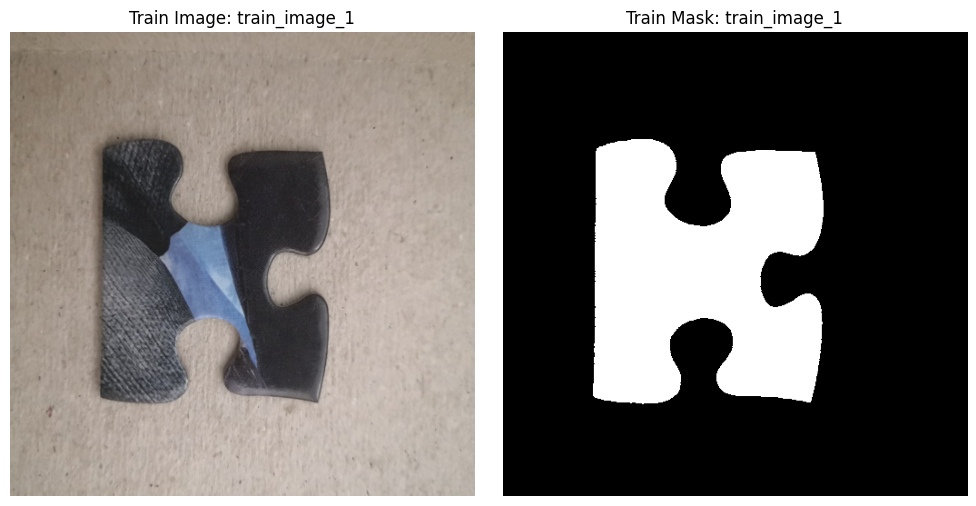

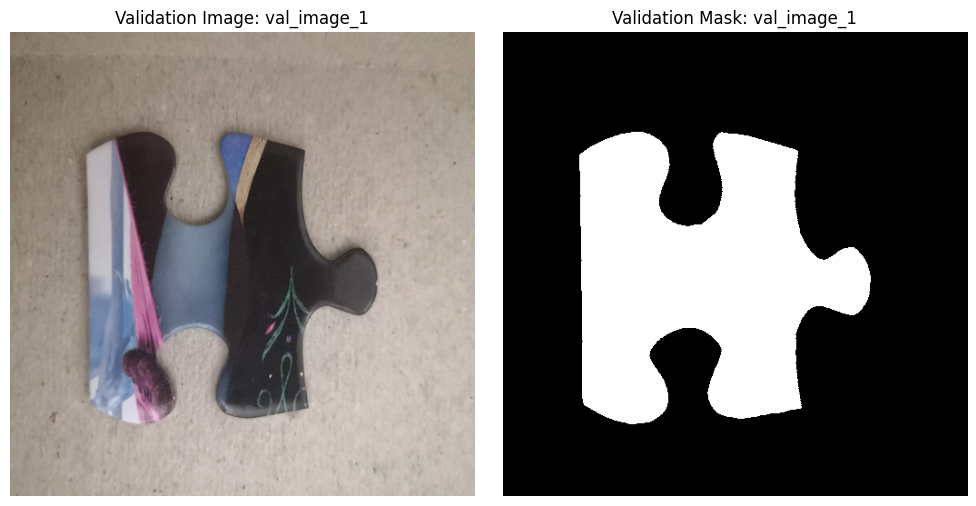

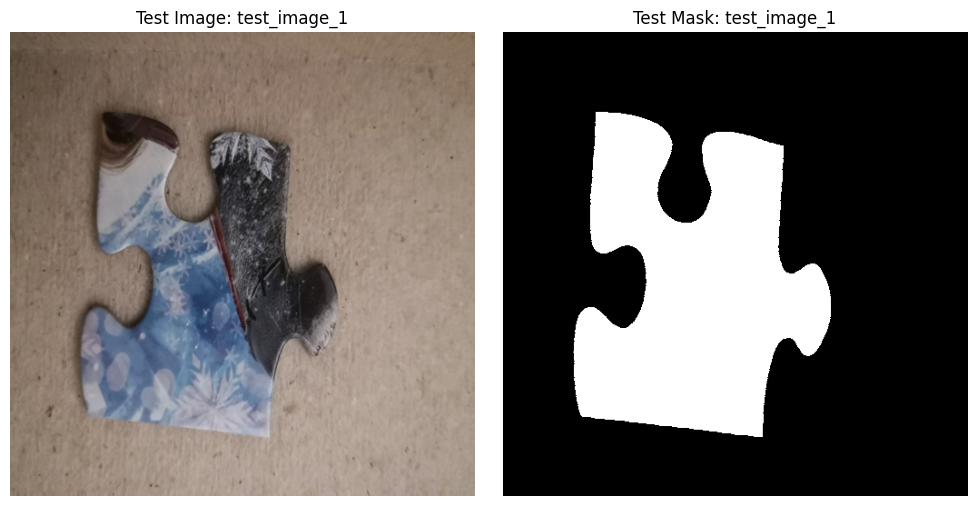

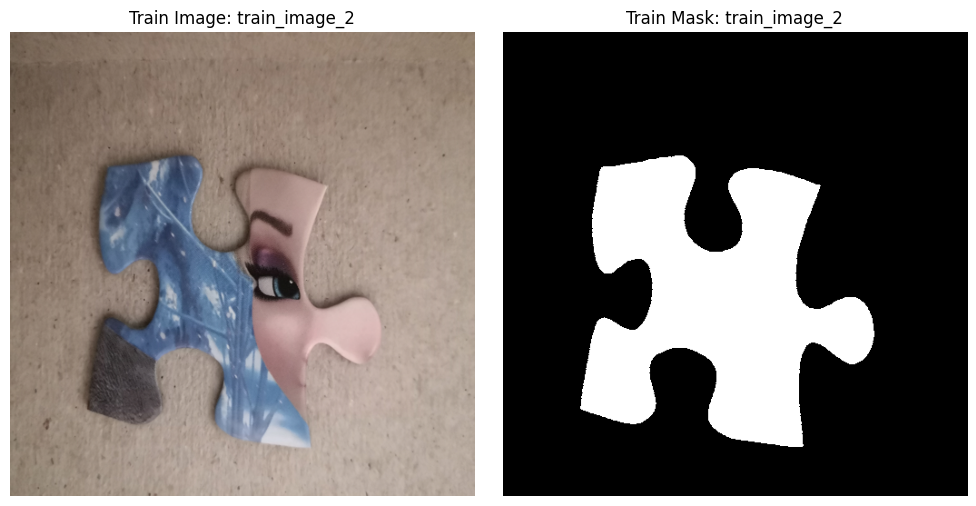

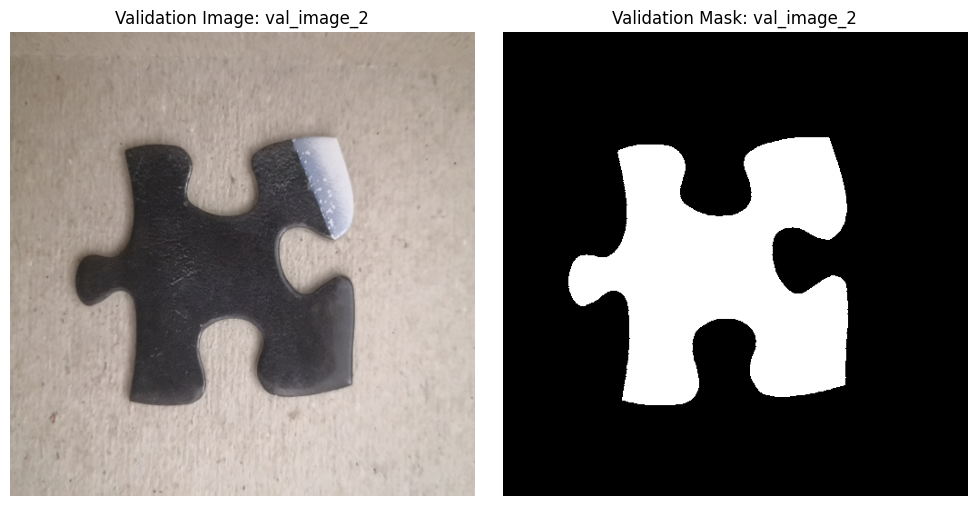

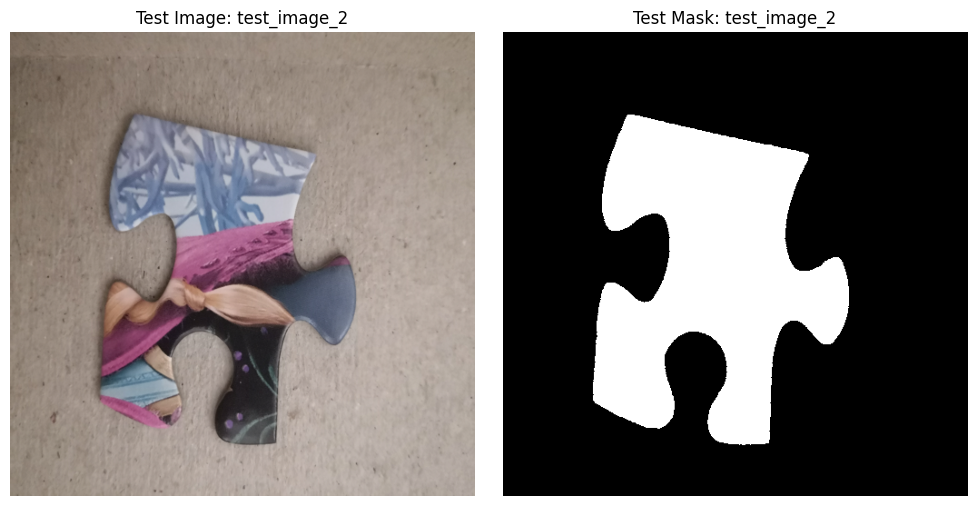

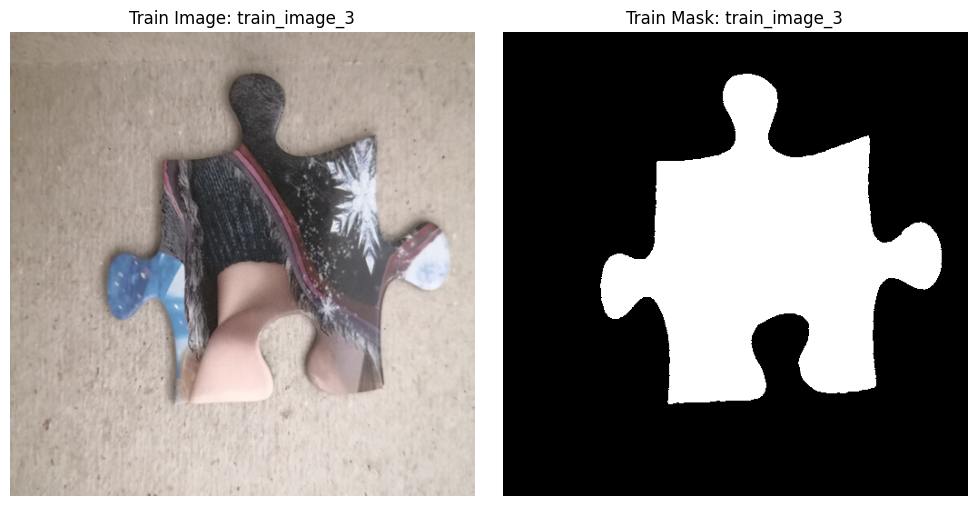

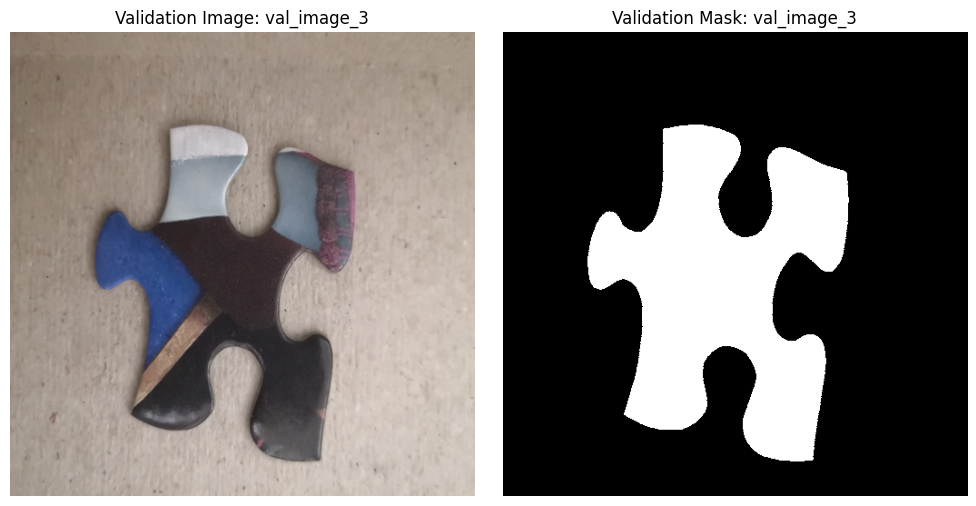

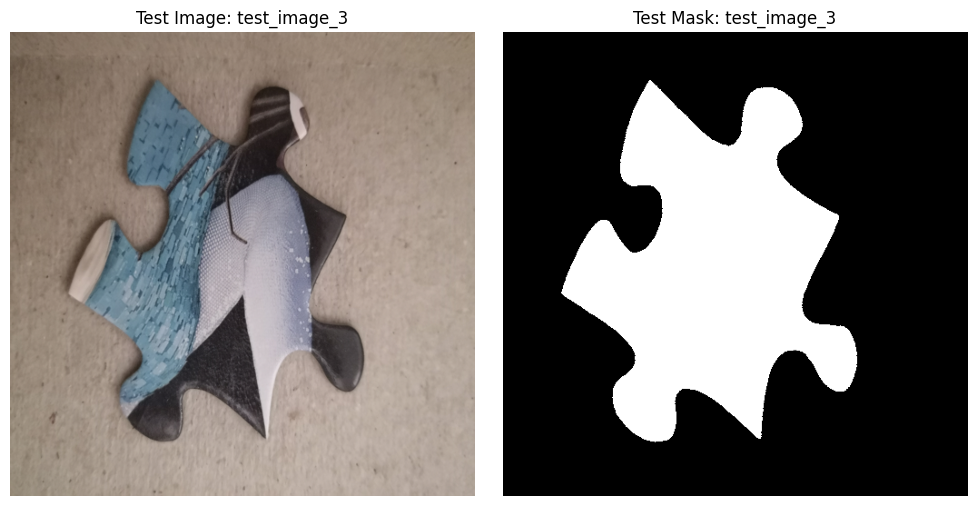

In [ ]:
# Plot image and mask
def plot_image_and_mask(image, mask, image_name, dataset_type):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'{dataset_type} Image: {image_name}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'{dataset_type} Mask: {image_name}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Extract train, val, and test sets
X_train, Y_train = datasets['X_train'], datasets['Y_train']
X_val, Y_val = datasets['X_val'], datasets['Y_val']
X_test, Y_test = datasets['X_test'], datasets['Y_test']

# Plot some examples from the datasets
for i in range(3):  # Show 3 examples from each dataset
    plot_image_and_mask(X_train[i], Y_train[i], f'train_image_{i+1}', 'Train')
    plot_image_and_mask(X_val[i], Y_val[i], f'val_image_{i+1}', 'Validation')
    plot_image_and_mask(X_test[i], Y_test[i], f'test_image_{i+1}', 'Test')

Variant 1: U-Net with ConvTranspose2d

In [ ]:
# U-Net with ConvTranspose2d for upsampling
class UNetConvTranspose(nn.Module):
    def __init__(self):
        super(UNetConvTranspose, self).__init__()

        # Downsampling Path
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Upsampling Path with ConvTranspose2d
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Output layer: 2 channels (background and foreground)
        self.output_conv = nn.Conv2d(64, 2, kernel_size=1)

    def forward(self, x):
        # Downsample
        x1 = self.conv1(x)
        p1 = self.pool1(x1)
        x2 = self.conv2(p1)
        p2 = self.pool2(x2)
        x3 = self.conv3(p2)
        p3 = self.pool3(x3)
        x4 = self.conv4(p3)
        p4 = self.pool4(x4)

        # Bottleneck
        bottleneck = self.conv5(p4)

        # Upsample
        up4 = self.upconv4(bottleneck)
        up4 = torch.cat([up4, x4], dim=1)
        up4 = self.conv6(up4)

        up3 = self.upconv3(up4)
        up3 = torch.cat([up3, x3], dim=1)
        up3 = self.conv7(up3)

        up2 = self.upconv2(up3)
        up2 = torch.cat([up2, x2], dim=1)
        up2 = self.conv8(up2)

        up1 = self.upconv1(up2)
        up1 = torch.cat([up1, x1], dim=1)
        up1 = self.conv9(up1)

        output = self.output_conv(up1)
        probabilities = F.softmax(output, dim=1)
        binary_mask = probabilities[:, 1, :, :]
        binary_mask = binary_mask.unsqueeze(1)  # Add channel dimension

        return binary_mask.to(dtype=torch.float)

# Print architecture for ConvTranspose2d U-Net
model_convtranspose = UNetConvTranspose()
print(model_convtranspose)

UNetConvTranspose(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequent

Variant 2: U-Net with Upsample for Bilinear Upsampling

In [ ]:
# U-Net with Upsample for bilinear upsampling
class UNetUpsample(nn.Module):
    def __init__(self):
        super(UNetUpsample, self).__init__()

        # Downsampling Path
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck (additional downsampling layer)
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Upsampling Path with Upsample (Bilinear)
        self.upsample4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv6 = nn.Sequential(
            nn.Conv2d(1024 + 512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv7 = nn.Sequential(
            nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv8 = nn.Sequential(
            nn.Conv2d(256 + 128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv9 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Output layer: 2 channels (background and foreground)
        self.output_conv = nn.Conv2d(64, 2, kernel_size=1)

    def forward(self, x):
        # Downsample
        x1 = self.conv1(x)
        p1 = self.pool1(x1)
        x2 = self.conv2(p1)
        p2 = self.pool2(x2)
        x3 = self.conv3(p2)
        p3 = self.pool3(x3)
        x4 = self.conv4(p3)
        p4 = self.pool4(x4)

        # Bottleneck
        bottleneck = self.conv5(p4)

        # Upsample
        up4 = self.upsample4(bottleneck)
        up4 = torch.cat([up4, x4], dim=1)
        up4 = self.conv6(up4)

        up3 = self.upsample3(up4)
        up3 = torch.cat([up3, x3], dim=1)
        up3 = self.conv7(up3)

        up2 = self.upsample2(up3)
        up2 = torch.cat([up2, x2], dim=1)
        up2 = self.conv8(up2)

        up1 = self.upsample1(up2)
        up1 = torch.cat([up1, x1], dim=1)
        up1 = self.conv9(up1)

        # Output
        output = self.output_conv(up1)
        probabilities = F.softmax(output, dim=1)
        binary_mask = probabilities[:, 1, :, :]  # Take the foreground probability
        binary_mask = binary_mask.unsqueeze(1)  # Add channel dimension

        return binary_mask.to(dtype=torch.float)

# Print architecture for Upsample U-Net
model_upsample = UNetUpsample()
print(model_upsample)

UNetUpsample(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(


TRAINING AND EVALUATION

In [ ]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss, train_iou = 0, 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs,  masks.float()) # Binary cross-entropy
        loss.backward()
        optimizer.step()

        # Track loss and IoU
        train_loss += loss.item()
        train_iou += compute_iou(outputs, masks)

    # Average the loss and IoU over the batches
    train_loss /= len(train_loader)
    train_iou /= len(train_loader)

    return train_loss, train_iou

In [ ]:
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss, val_iou = 0, 0

    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            val_outputs = model(val_images)

            # Compute validation loss
            val_loss += criterion(val_outputs, val_masks.float()).item()
            val_iou += compute_iou(val_outputs, val_masks)

    # Average validation loss and IoU over batches
    val_loss /= len(val_loader)
    val_iou /= len(val_loader)

    return val_loss, val_iou

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    test_iou = 0

    with torch.no_grad():
        for test_images, test_masks in test_loader:
            test_images, test_masks = test_images.to(device), test_masks.to(device)

            # Get model predictions
            test_outputs = model(test_images)

            # Select the first channel for binary segmentation (foreground) if there's only one channel
            test_outputs = test_outputs[:, 0, :, :].unsqueeze(1) if test_outputs.shape[1] == 1 else test_outputs[:, 1, :, :].unsqueeze(1)
            # Apply threshold to get binary predictions
            test_outputs = (test_outputs > 0.5).float()

            # Ensure same shape for predictions and targets before reshaping
            if test_outputs.shape != test_masks.shape:

                #print(f"Resizing model output from {test_outputs.shape} to {test_masks.shape}")
                test_outputs = F.interpolate(test_outputs, size=test_masks.shape[2:], mode="bilinear", align_corners=False)

            # Convert predictions and masks to binary 1D arrays
            preds = test_outputs.cpu().numpy().astype(int).reshape(-1)
            labels = test_masks.cpu().numpy().astype(int).reshape(-1)

            # Append for final evaluation
            y_true.extend(labels)
            y_pred.extend(preds)

            # Compute IoU for the current batch
            test_iou += compute_iou(test_outputs, test_masks)

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="binary")
    recall = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")
    iou = jaccard_score(y_true, y_pred, average="binary")

    return accuracy, precision, recall, f1, iou

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device):

    for epoch in range(num_epochs):
        # Train for one epoch
        train_loss, train_iou = train_one_epoch(model, train_loader, optimizer, criterion, device)

        # Validate for one epoch
        val_loss, val_iou = validate_one_epoch(model, val_loader, criterion, device)

        # Log metrics to wandb
        log_metrics_to_wandb(epoch, train_loss, train_iou, val_loss, val_iou)

        # Print metrics for the epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}')

        # Save model checkpoint
        torch.save(model.state_dict(), f"model_checkpoint_epoch_{epoch+1}.pth")


In [ ]:
# Initialize an empty DataFrame to store metrics
metrics_df = pd.DataFrame(columns=["Model Name", "Accuracy", "Precision", "Recall", "F1 Score", "IoU"])

def test_model(model, model_name, test_loader, device):
    accuracy, precision, recall, f1, iou = evaluate_model(model, test_loader, device)

    # Log test metrics to wandb
    wandb.log({
        "test_accuracy": accuracy,
        "test_precision": precision,
        "test_recall": recall,
        "test_f1": f1,
        "test_iou": iou
    })

    # Print individual model metrics
    print(f"Test Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, IoU: {iou:.4f}\n")

    # Append the metrics to the DataFrame
    global metrics_df
    metrics_df = pd.concat([metrics_df, pd.DataFrame([{
        "Model Name": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "IoU": iou
}])], ignore_index=True)

# Function to print the table of model metrics
def print_final_metrics_table():
    print("\nFinal Table of Model Evaluation Metrics:")
    print(metrics_df)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, masks, image_transform=None, mask_transform=None):
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)  # Convert to (C, H, W)
        mask = torch.tensor(self.masks[idx], dtype=torch.float32).unsqueeze(0)  # Convert to (1, H, W)

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        # Convert mask to binary (0: background, 1: foreground)
        mask = (mask > 0).float()

        return image, mask

# Define transformations for images and masks separately
image_transform = None

mask_transform = None

# Define your datasets and dataloaders
train_dataset = CustomDataset(X_train, Y_train, image_transform=image_transform, mask_transform=mask_transform)
val_dataset = CustomDataset(X_val, Y_val, image_transform=image_transform, mask_transform=mask_transform)
test_dataset = CustomDataset(X_test, Y_test, image_transform=image_transform, mask_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [ ]:
def compute_iou(outputs, masks, threshold=0.5):

    # Assuming outputs are already foreground probabilities
    foreground_probs = outputs

    # Apply the threshold to convert probabilities to binary predictions
    pred_classes = (foreground_probs > threshold).float()

    # Flatten tensors for IoU computation
    pred_classes = pred_classes.squeeze(1).view(-1)
    masks = masks.squeeze(1).view(-1)

    # Calculate intersection and union
    intersection = torch.sum((pred_classes == 1) & (masks == 1)).float()
    union = torch.sum((pred_classes == 1) | (masks == 1 )).float()

    # Compute IoU
    iou = intersection / (union + 1e-6)
    return iou.item()

In [ ]:
def log_metrics_to_wandb(epoch, train_loss, train_iou, val_loss, val_iou):
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_iou": train_iou,
        "val_loss": val_loss,
        "val_iou": val_iou
    })

In [ ]:
# Load and preprocess the image
def load_image(image_path, device, img_size=(512, 512)):
    img = Image.open(image_path).convert('RGB')

    # Preprocess the image (resize, to tensor, normalize)
    preprocess = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()
    ])

    img_tensor = preprocess(img).unsqueeze(0)
    return img_tensor.to(device), img

# Postprocess the output to get the segmentation mask
def postprocess_output(output):

    # Convert mask to binary (0 or 1) or you can threshold it
    output_cpu = output.cpu().detach()
    #threshold = threshold_otsu(output_cpu)
    binary_mask = output_cpu > 0.34
    # Squeeze to remove the first two dimensions
    segmented_img = np.squeeze(binary_mask.numpy())

    # Add a new axis at the end to get shape (512, 512, 1)
    mask = np.expand_dims(segmented_img, axis=-1)

    return mask

# Function to plot original and segmented mask
def plot_segmentation(original_img, mask):
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')
    plt.gca().set_aspect('equal', adjustable='box')

    # Plot segmentation mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Segmented Mask")
    plt.axis('off')
    plt.gca().set_aspect('equal', adjustable='box')

    plt.tight_layout()
    plt.show()

# Segment an image
def segment_image(image_path, model, device):
    model.eval()  # Set the model to evaluation mode

    # Load and preprocess the image
    img_tensor, original_img = load_image(image_path, device)

    # Perform inference
    with torch.no_grad():
        output = model(img_tensor)

    # Postprocess the output to get the segmentation mask
    mask = postprocess_output(output)

    # Plot the original image and the segmented mask
    plot_segmentation(original_img, mask)

image_path = '/content/drive/MyDrive/Lab 3/images/test/image-36.png'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RUNNING FOR UPSAMPLE

In [ ]:
# Initialize wandb project
wandb.init(project="unet-segmentation", config={"epochs": 50, "batch_size": 2})


# Set training parameters
num_epochs = 50
learning_rate = 0.0001

# Initialize model, criterion, optimizer
model_2 = UNetUpsample().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)

# Train the model
train_model(model_2, train_loader, val_loader, num_epochs, criterion, optimizer, device)

wandb.run

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch [1/50], Train Loss: 0.6870, Train IoU: 0.0255, Val Loss: 0.6744, Val IoU: 0.0000
Epoch [2/50], Train Loss: 0.6691, Train IoU: 0.0000, Val Loss: 0.6239, Val IoU: 0.0000
Epoch [3/50], Train Loss: 0.5995, Train IoU: 0.0000, Val Loss: 0.5438, Val IoU: 0.0000
Epoch [4/50], Train Loss: 0.5727, Train IoU: 0.0000, Val Loss: 0.5202, Val IoU: 0.0000
Epoch [5/50], Train Loss: 0.5632, Train IoU: 0.0000, Val Loss: 0.5054, Val IoU: 0.0000
Epoch [6/50], Train Loss: 0.5586, Train IoU: 0.0000, Val Loss: 0.4896, Val IoU: 0.0000
Epoch [7/50], Train Loss: 0.5490, Train IoU: 0.0000, Val Loss: 0.4805, Val IoU: 0.0000
Epoch [8/50], Train Loss: 0.5387, Train IoU: 0.0000, Val Loss: 0.4519, Val IoU: 0.0000
Epoch [9/50], Train Loss: 0.5275, Train IoU: 0.0000, Val Loss: 0.4118, Val IoU: 0.0000
Epoch [10/50], Train Loss: 0.4946, Train IoU: 0.0000, Val Loss: 0.3682, Val IoU: 0.0000
Epoch [11/50], Train Loss: 0.4352, Train IoU: 0.0000, Val Loss: 0.2945, Val IoU: 0.0000
Epoch [12/50], Train Loss: 0.4746, Train 

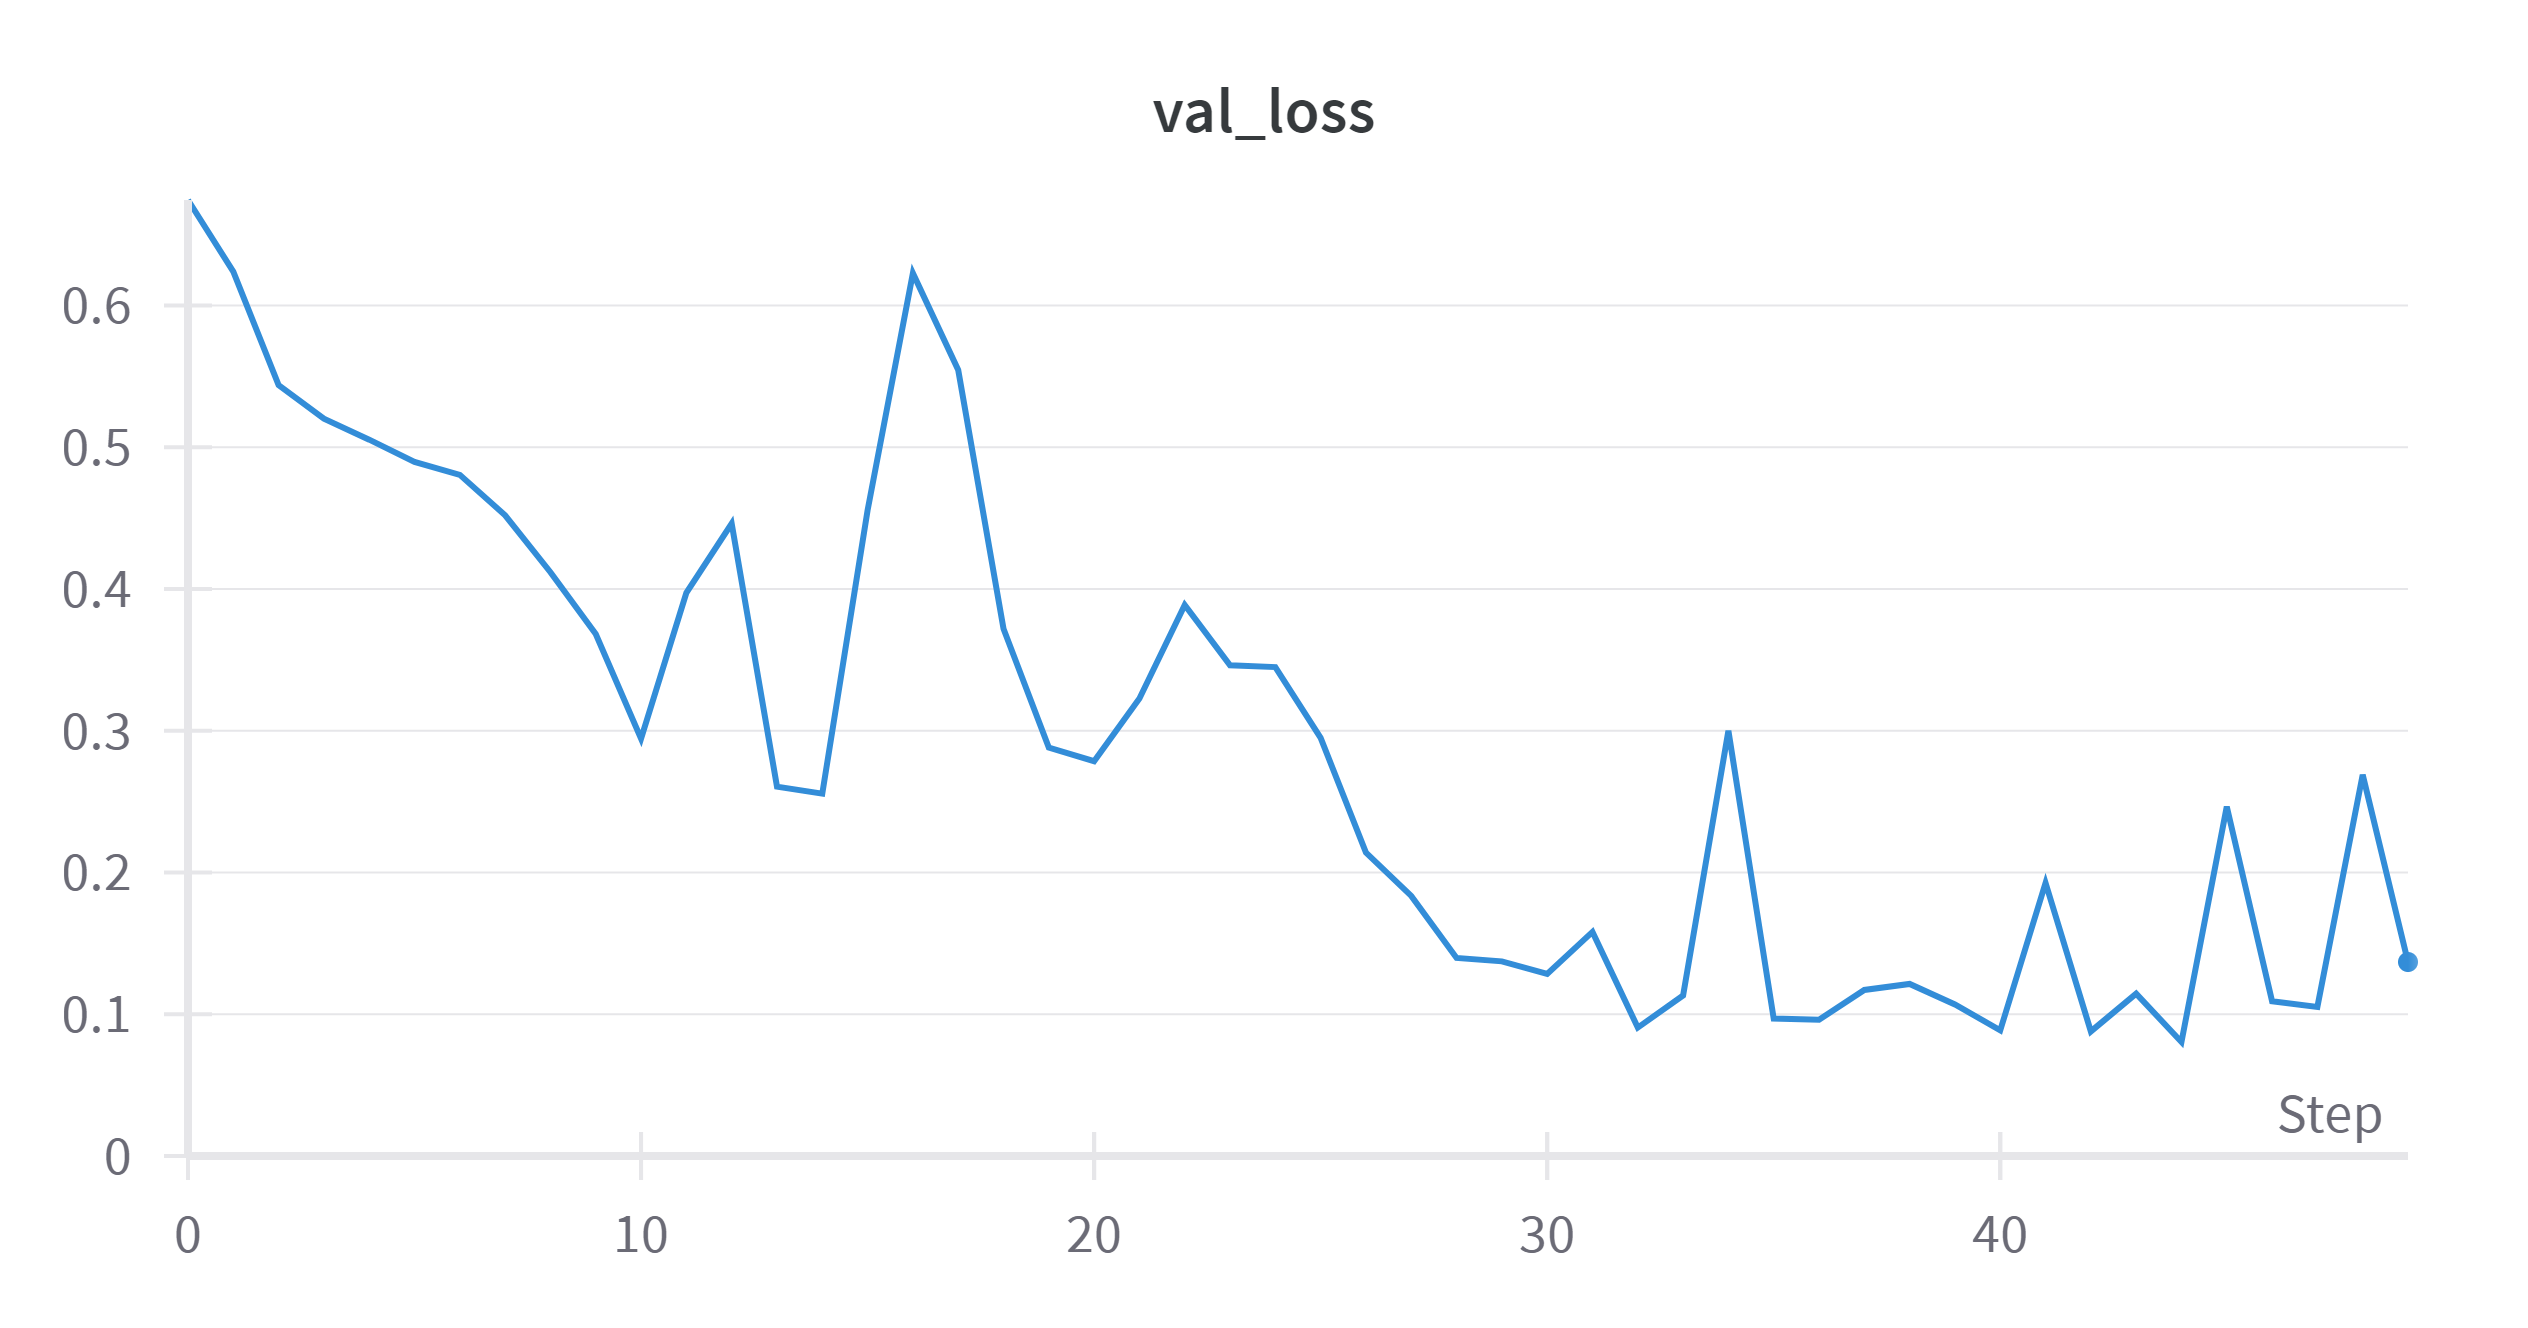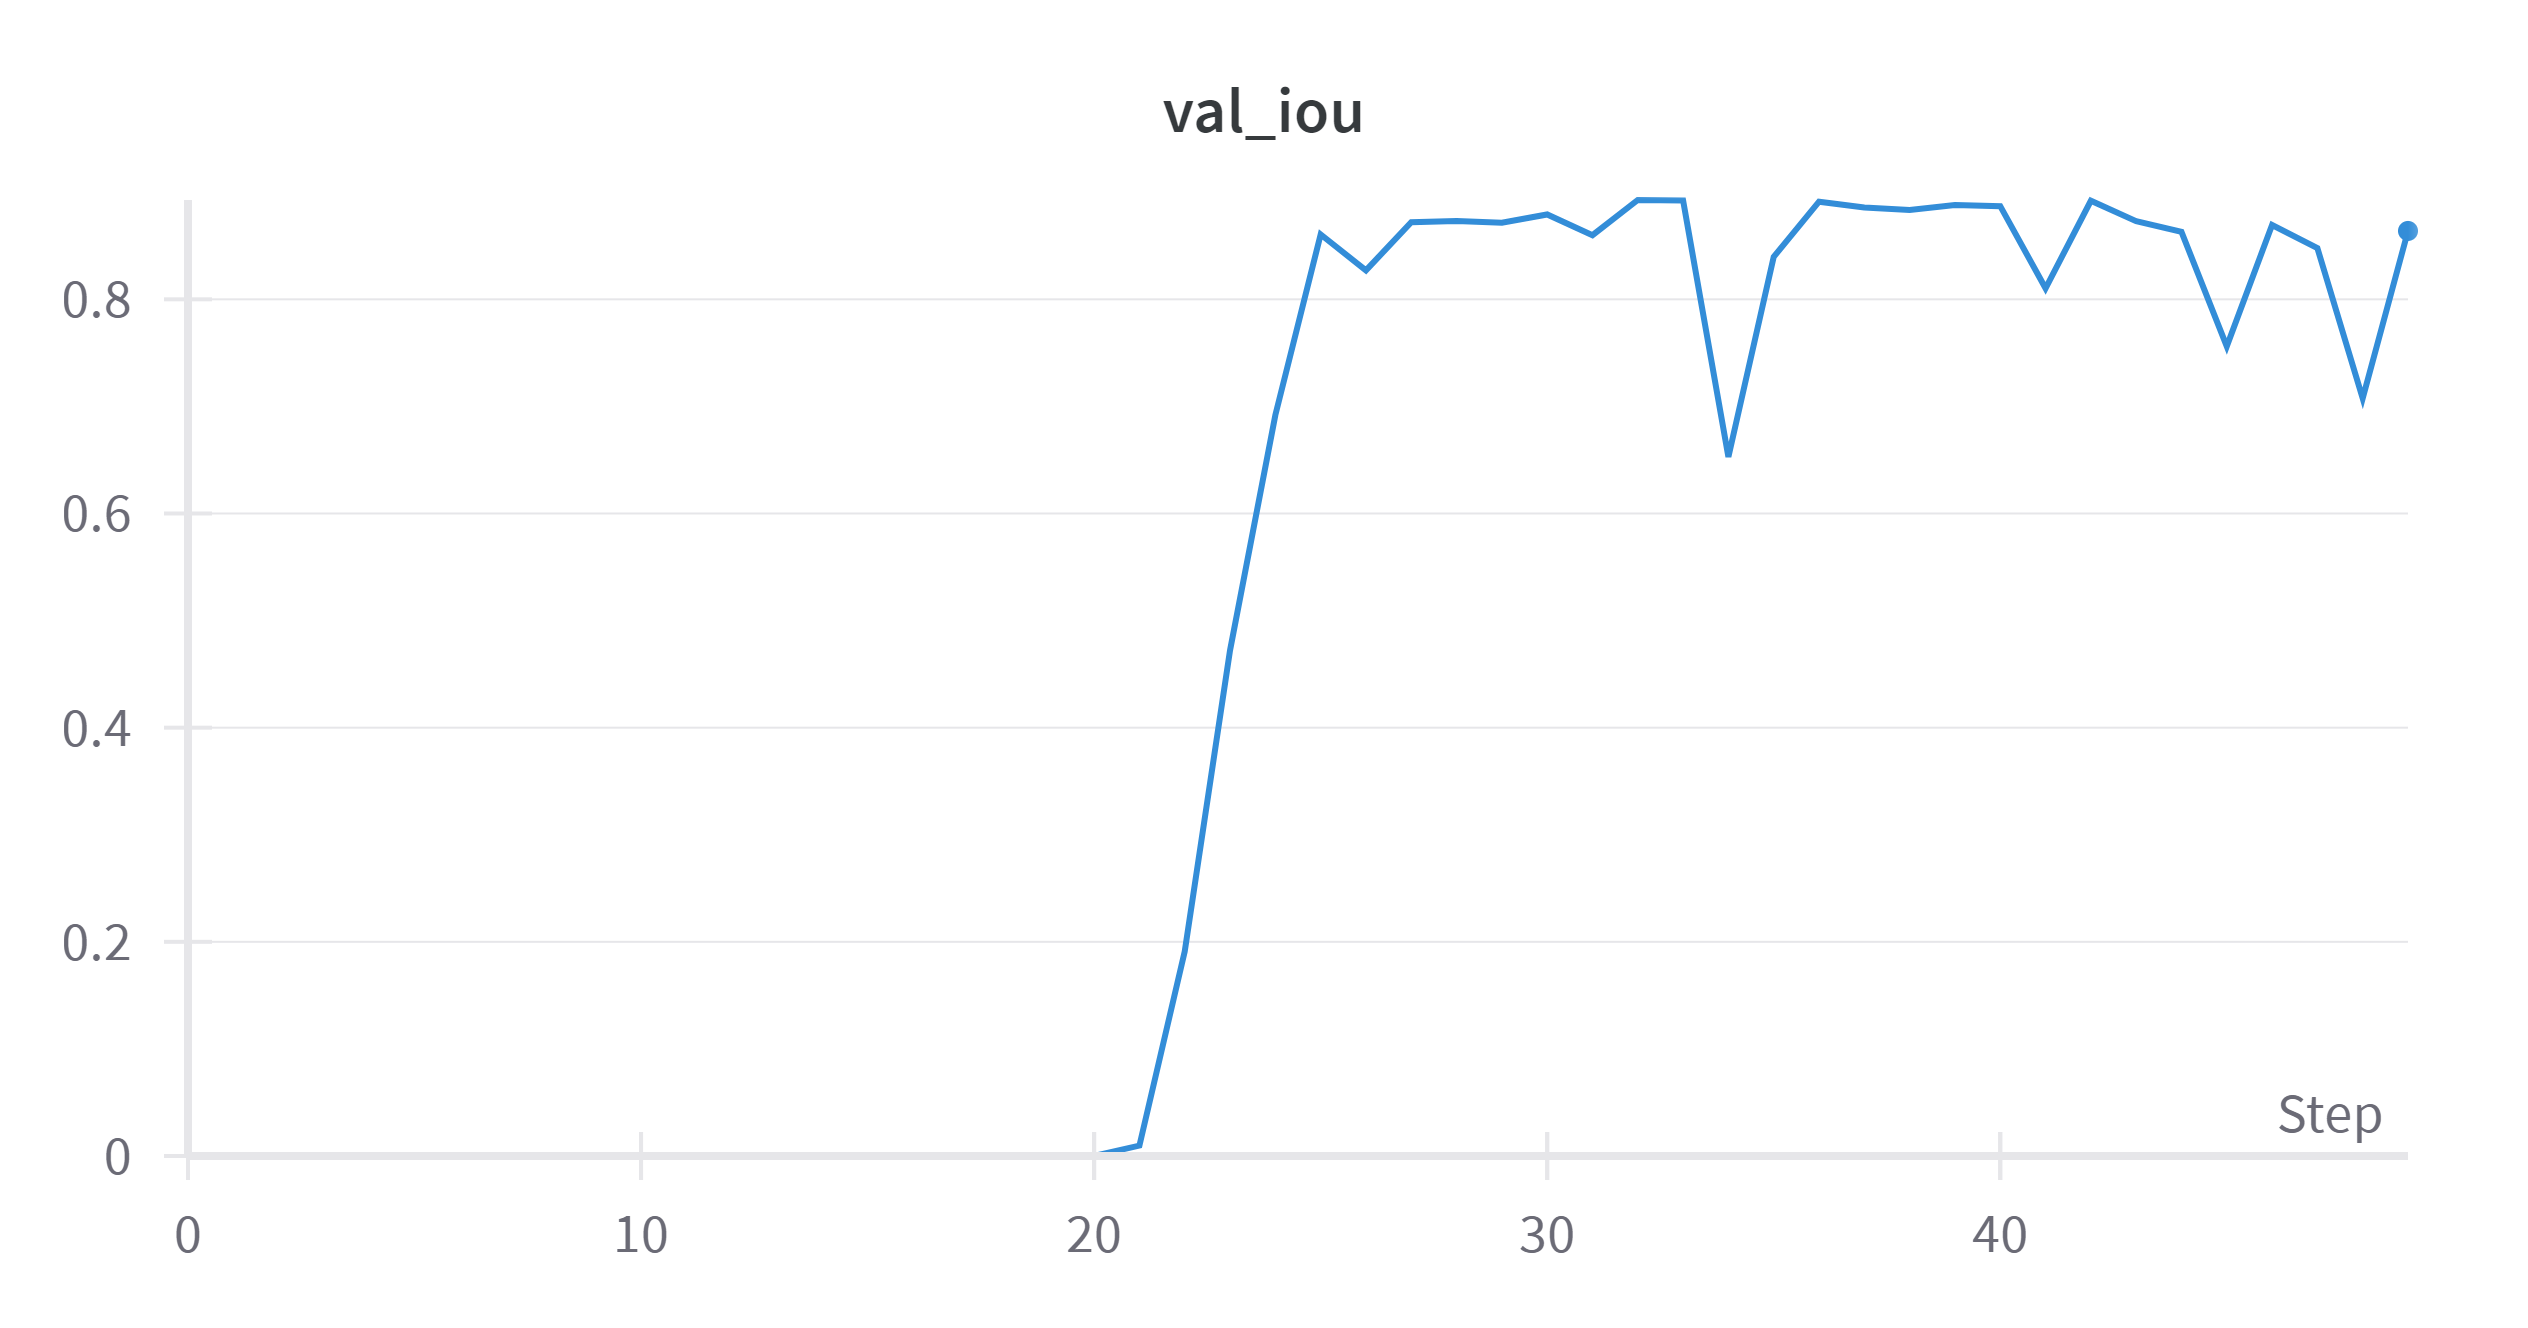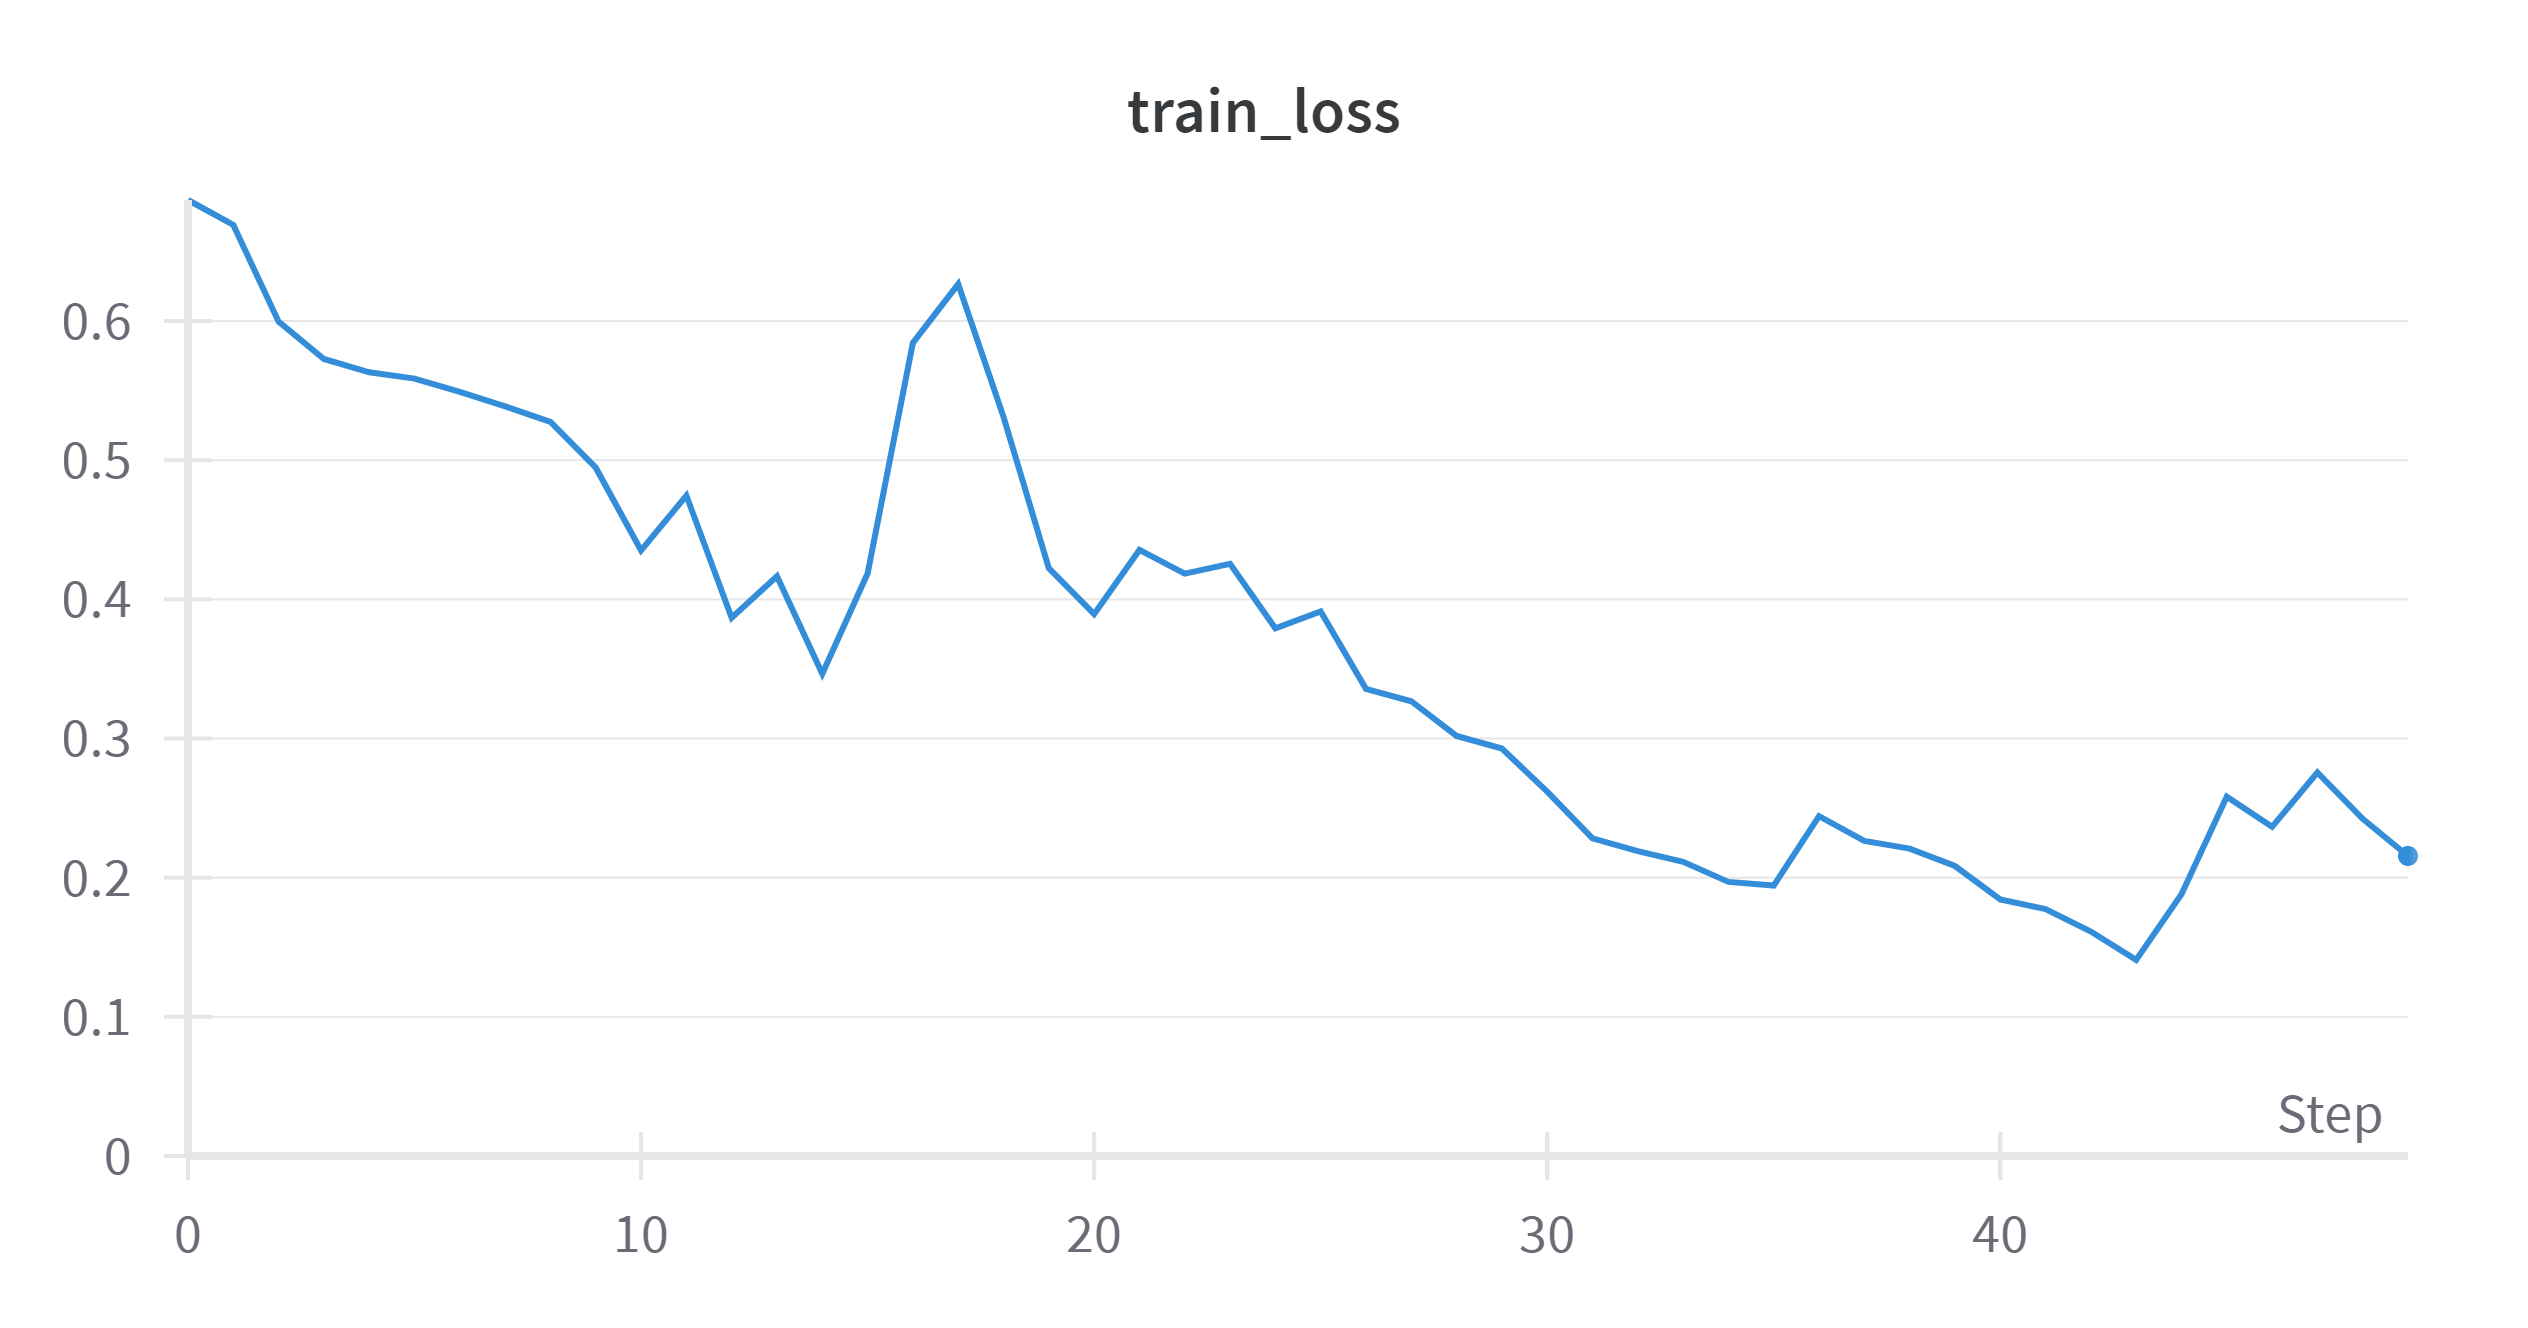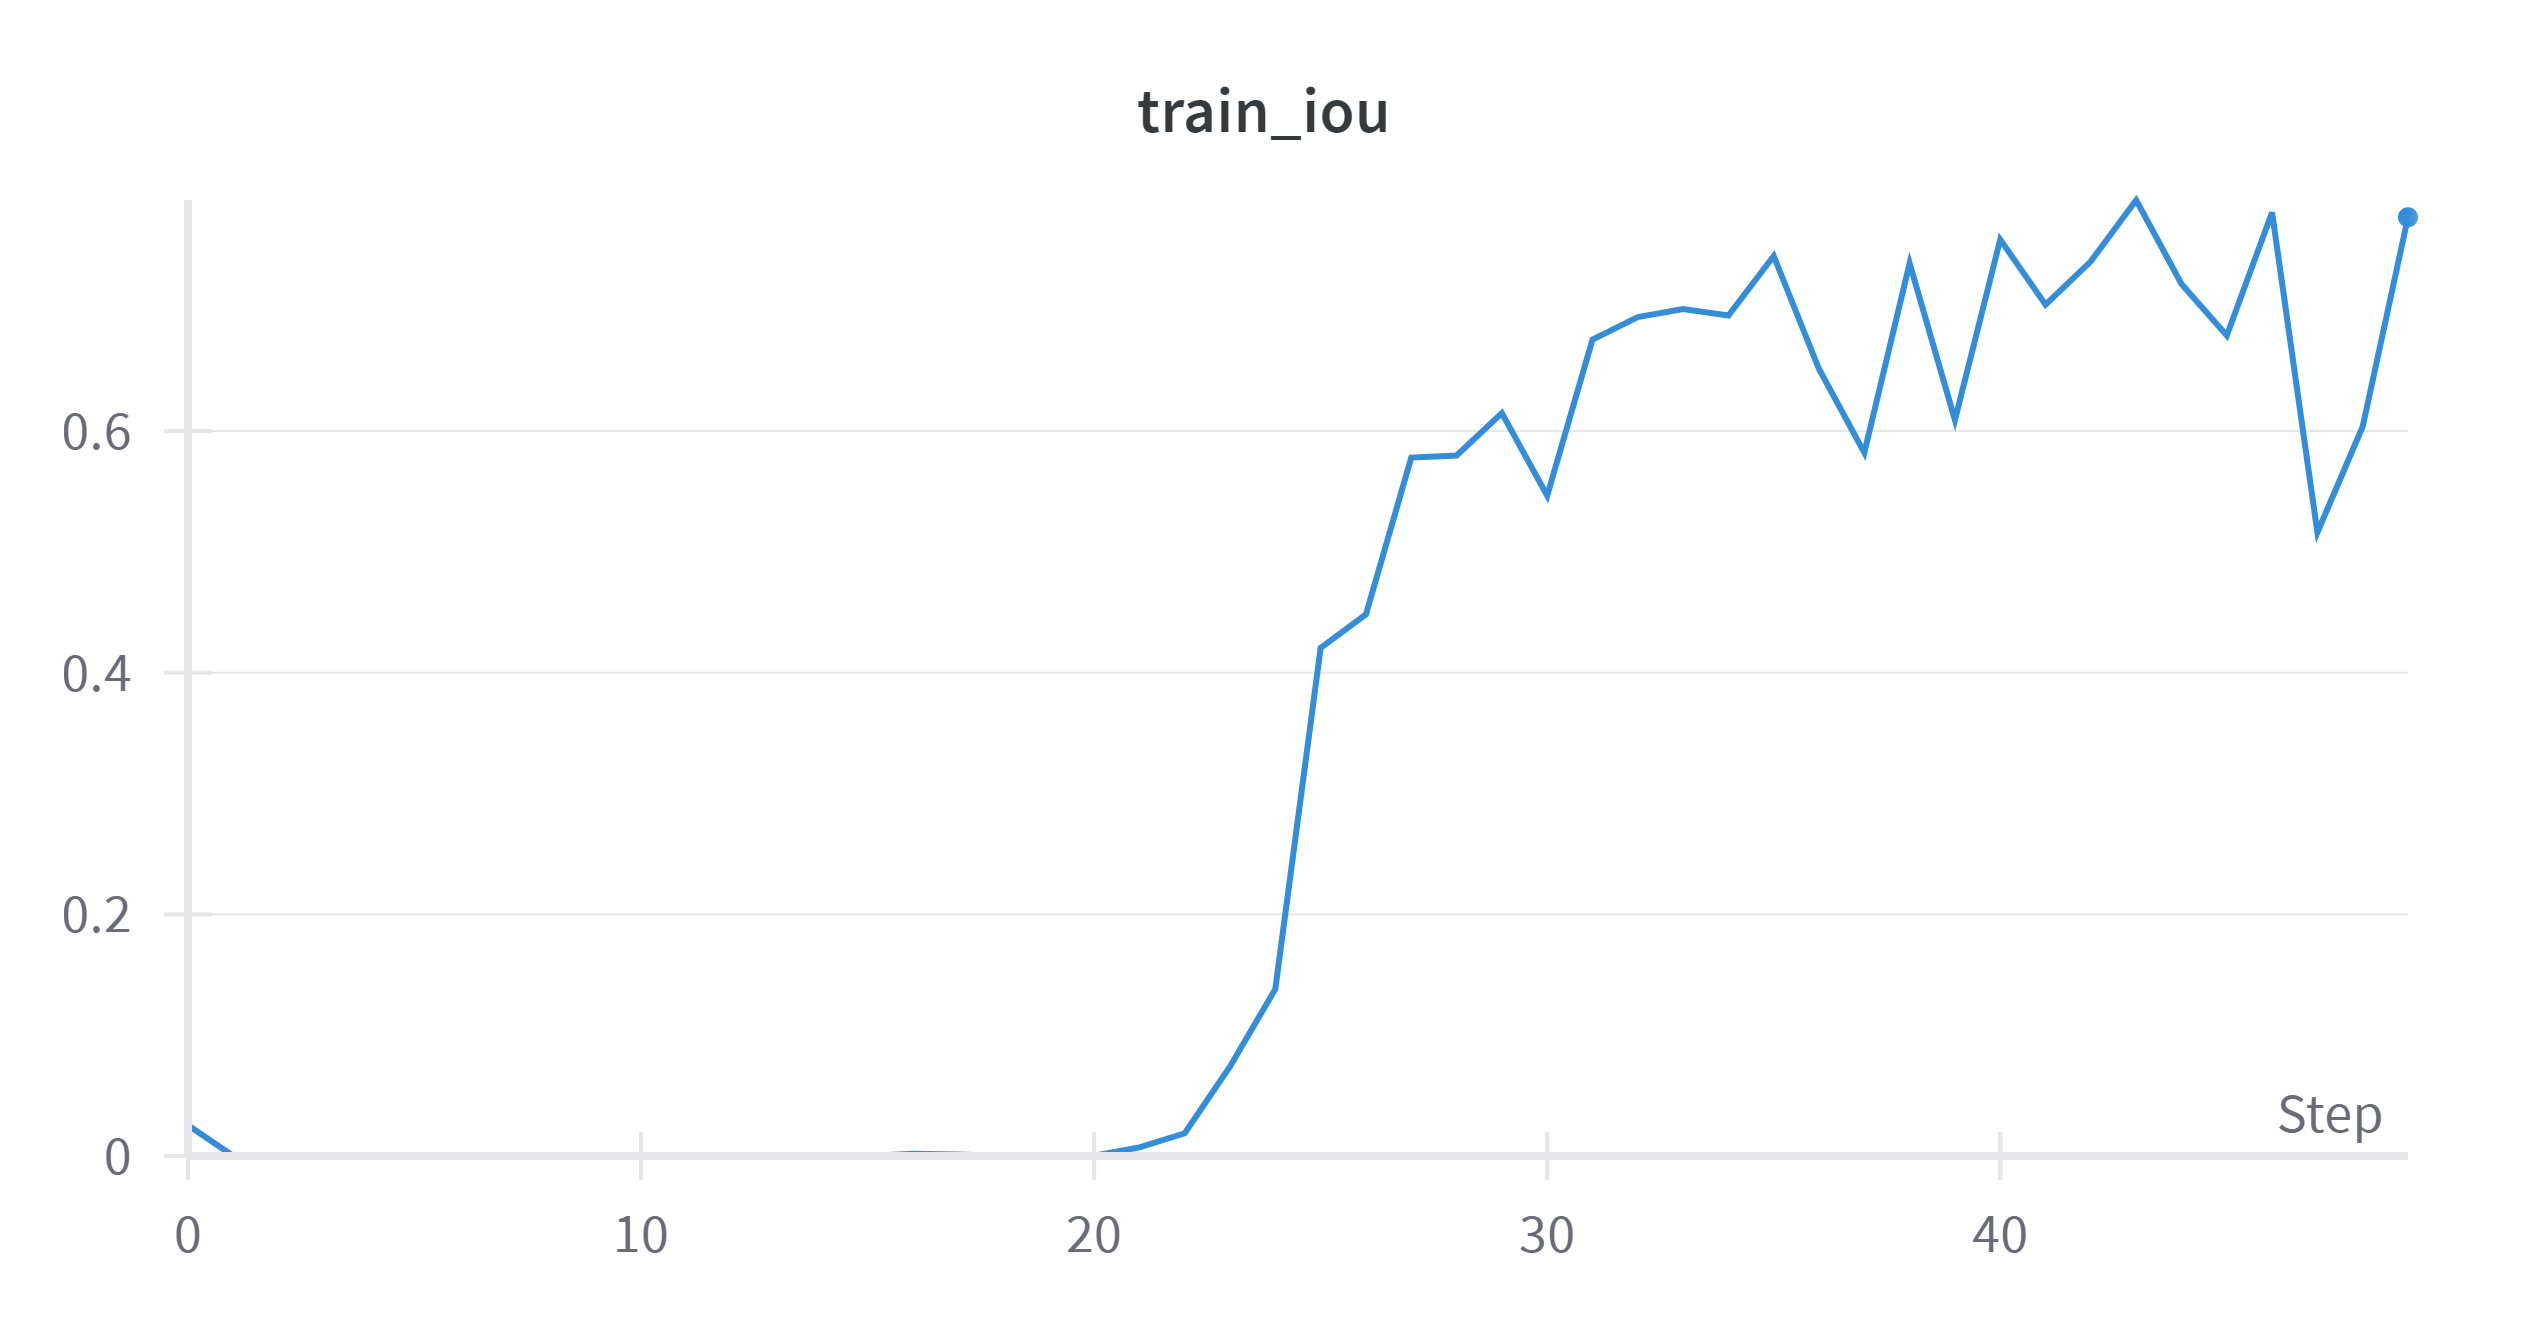

In [ ]:
# Test the model
test_model(model_2, "U-Net Upsample", test_loader, device)

Test Results for U-Net Upsample:
Accuracy: 0.9721, Precision: 0.9570, Recall: 0.9328, F1-Score: 0.9448, IoU: 0.8953



<ipython-input-19-54169cc2d50f>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([{


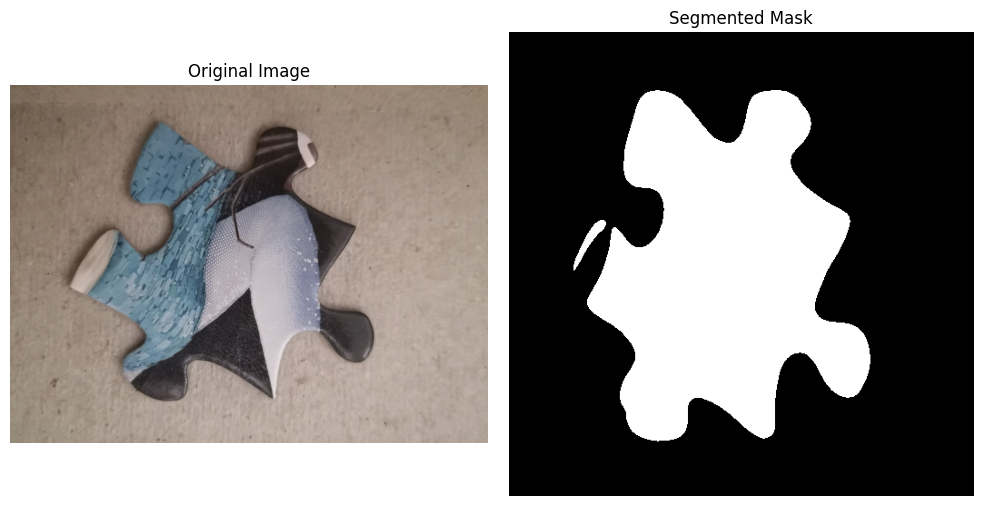

In [ ]:
# Assuming your trained model is loaded
segment_image(image_path, model_2, device)

RUNNING FOR CONVTRANSPONSE

In [ ]:
# Initialize wandb project
wandb.init(project="unet-segmentation", config={"epochs": 50, "batch_size": 2})

# Set training parameters
num_epochs = 50
learning_rate = 0.0001

# Initialize model, criterion, optimizer
model_1 = UNetConvTranspose().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)

# Train the model
train_model(model_1, train_loader, val_loader, num_epochs, criterion, optimizer, device)

wandb.run

Epoch [1/50], Train Loss: 0.6468, Train IoU: 0.0000, Val Loss: 0.6343, Val IoU: 0.0000
Epoch [2/50], Train Loss: 0.6339, Train IoU: 0.0000, Val Loss: 0.6149, Val IoU: 0.0000
Epoch [3/50], Train Loss: 0.6169, Train IoU: 0.0000, Val Loss: 0.5859, Val IoU: 0.0000
Epoch [4/50], Train Loss: 0.5906, Train IoU: 0.0000, Val Loss: 0.5322, Val IoU: 0.0000
Epoch [5/50], Train Loss: 0.5602, Train IoU: 0.0000, Val Loss: 0.4838, Val IoU: 0.0000
Epoch [6/50], Train Loss: 0.5471, Train IoU: 0.0000, Val Loss: 0.4832, Val IoU: 0.0000
Epoch [7/50], Train Loss: 0.5439, Train IoU: 0.0000, Val Loss: 0.4758, Val IoU: 0.0000
Epoch [8/50], Train Loss: 0.5411, Train IoU: 0.0000, Val Loss: 0.4747, Val IoU: 0.0000
Epoch [9/50], Train Loss: 0.5387, Train IoU: 0.0000, Val Loss: 0.4714, Val IoU: 0.0000
Epoch [10/50], Train Loss: 0.5367, Train IoU: 0.0000, Val Loss: 0.4624, Val IoU: 0.0000
Epoch [11/50], Train Loss: 0.5331, Train IoU: 0.0000, Val Loss: 0.4593, Val IoU: 0.0000
Epoch [12/50], Train Loss: 0.5290, Train 

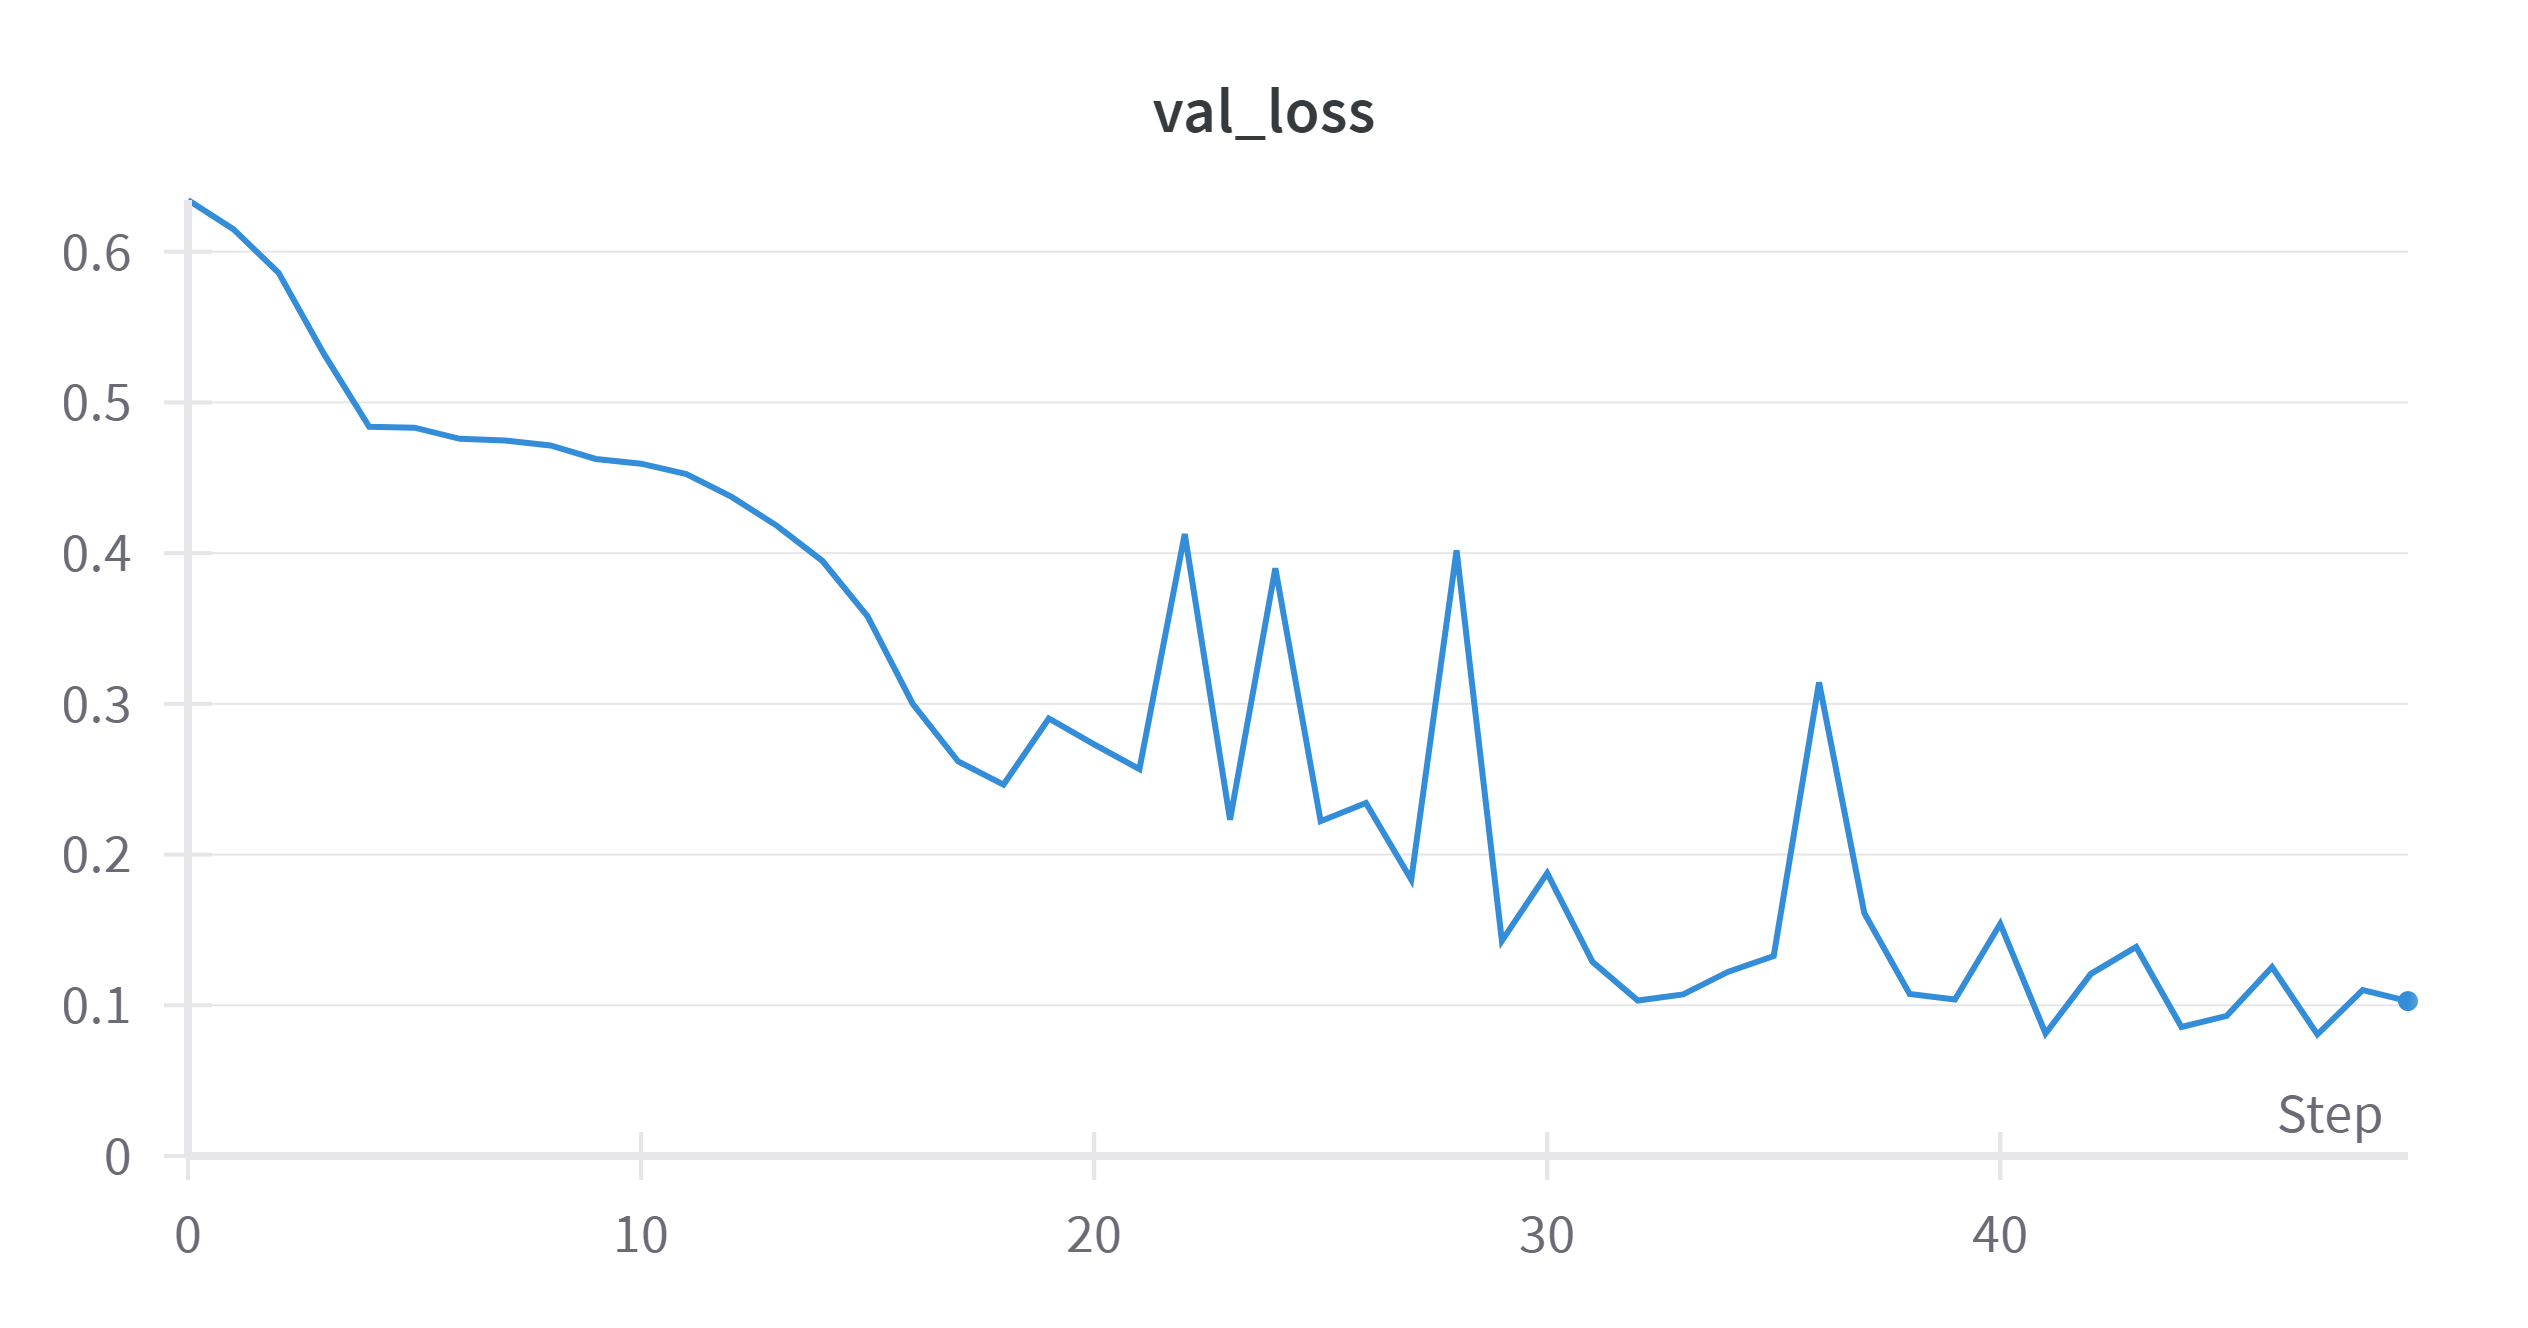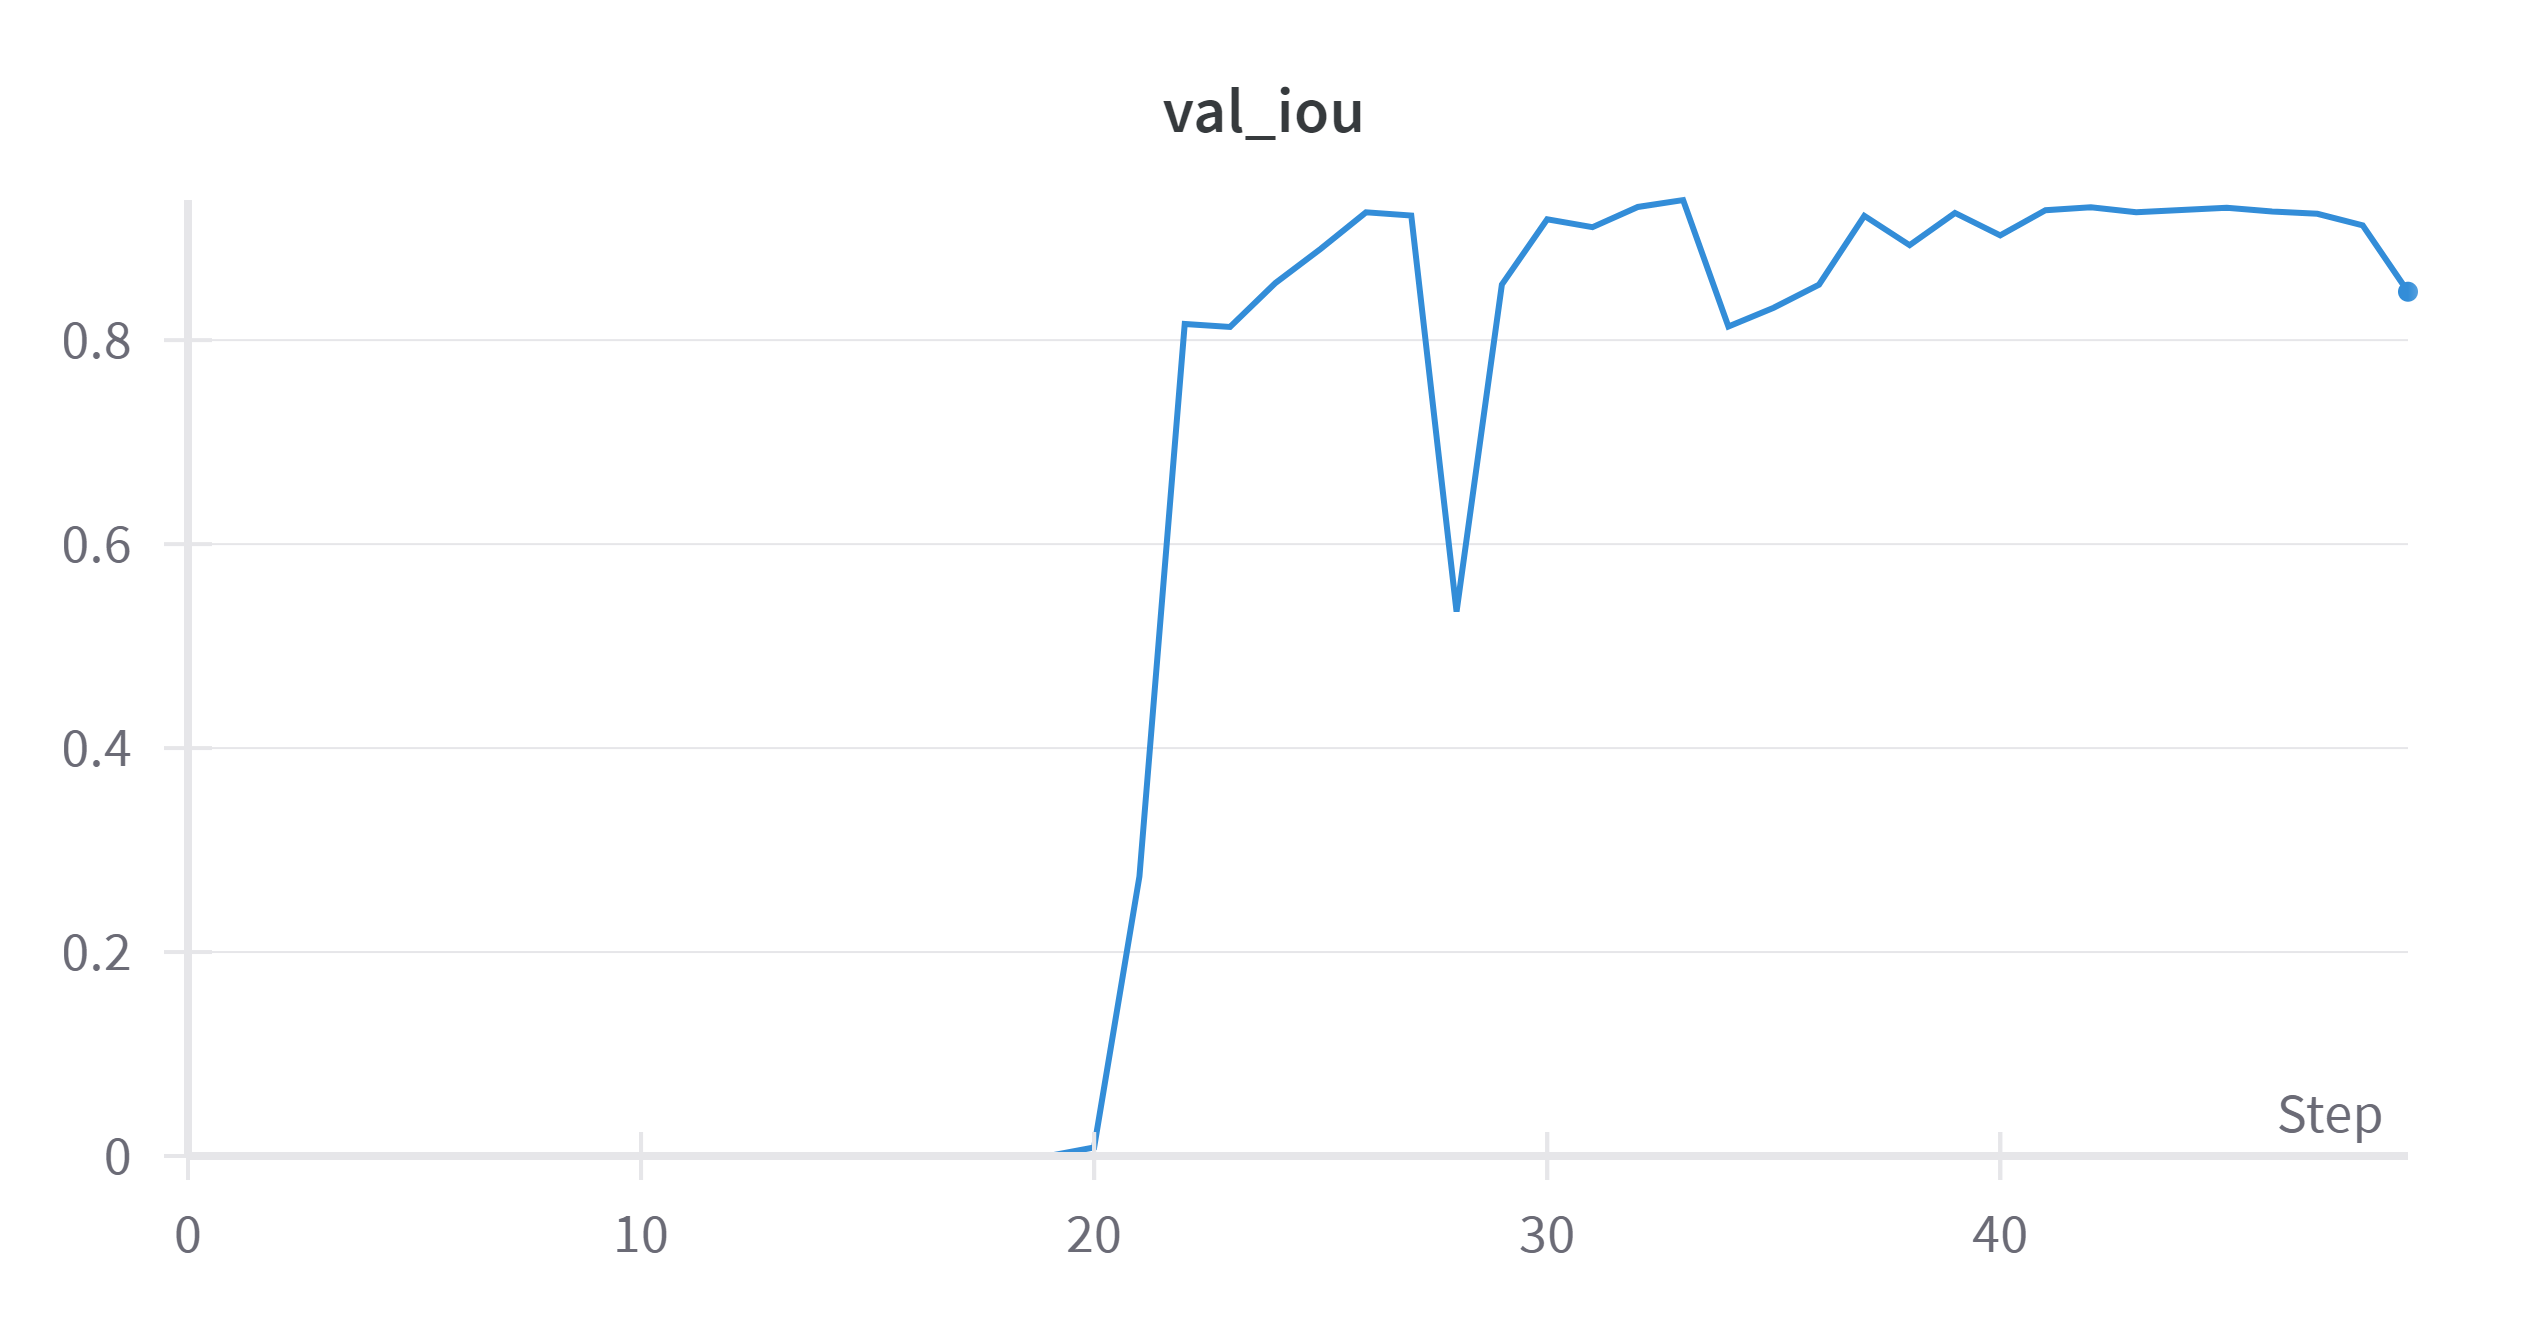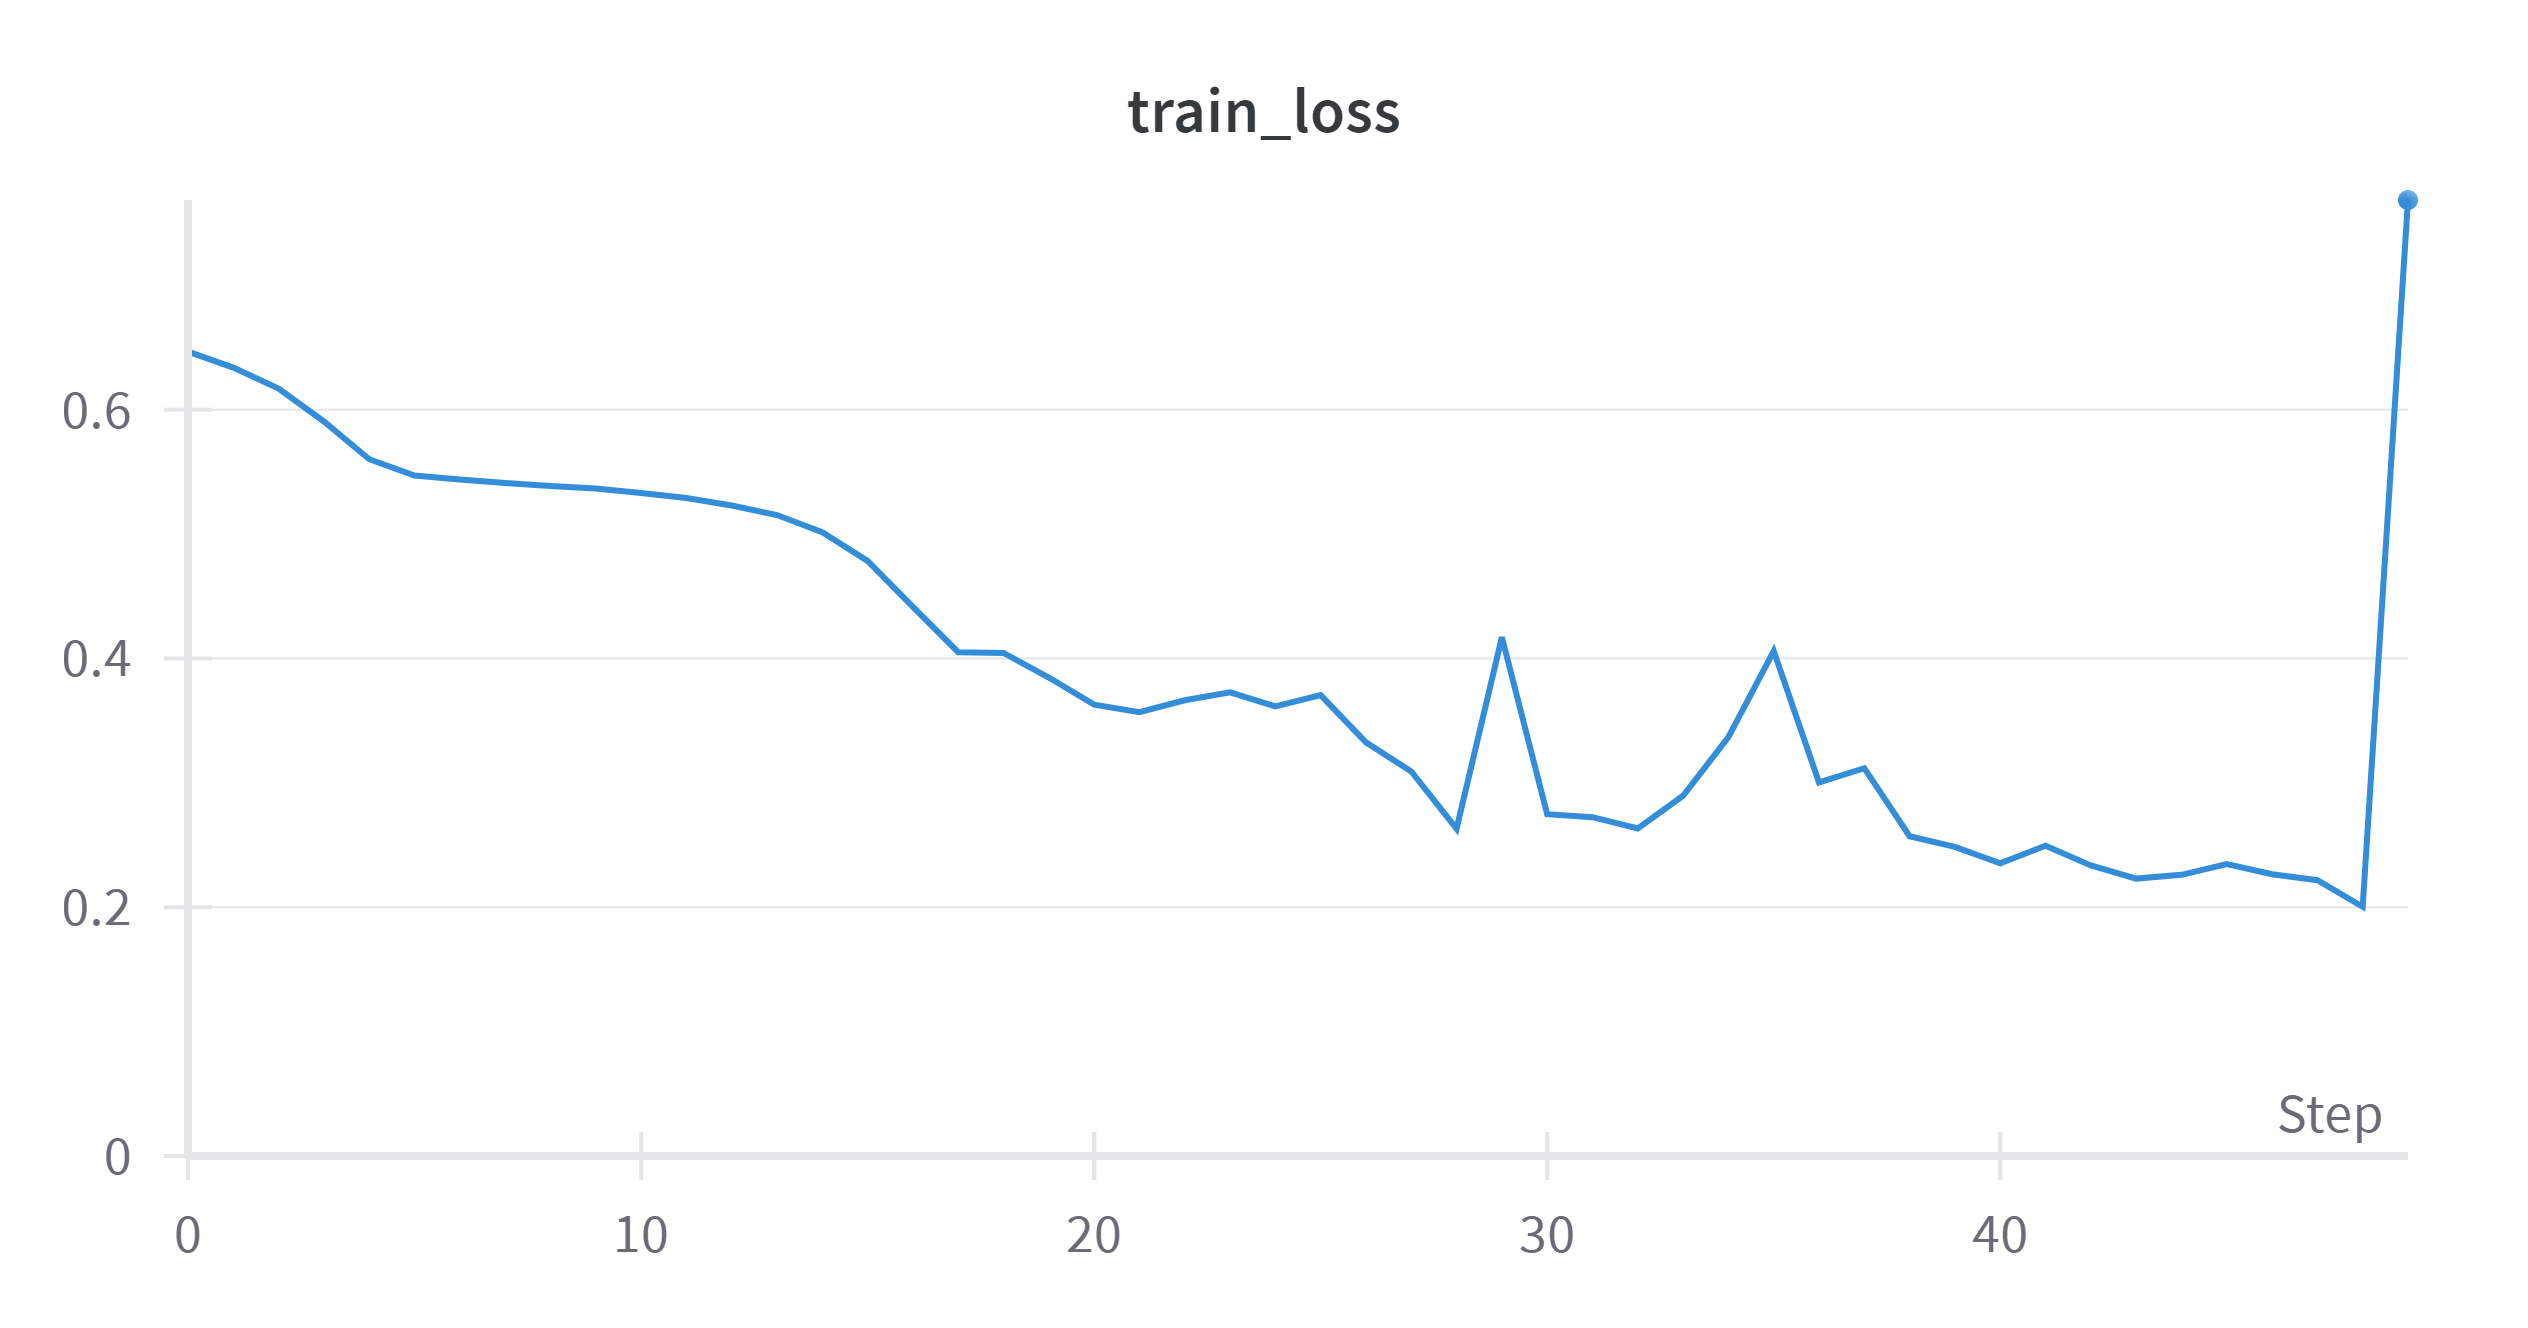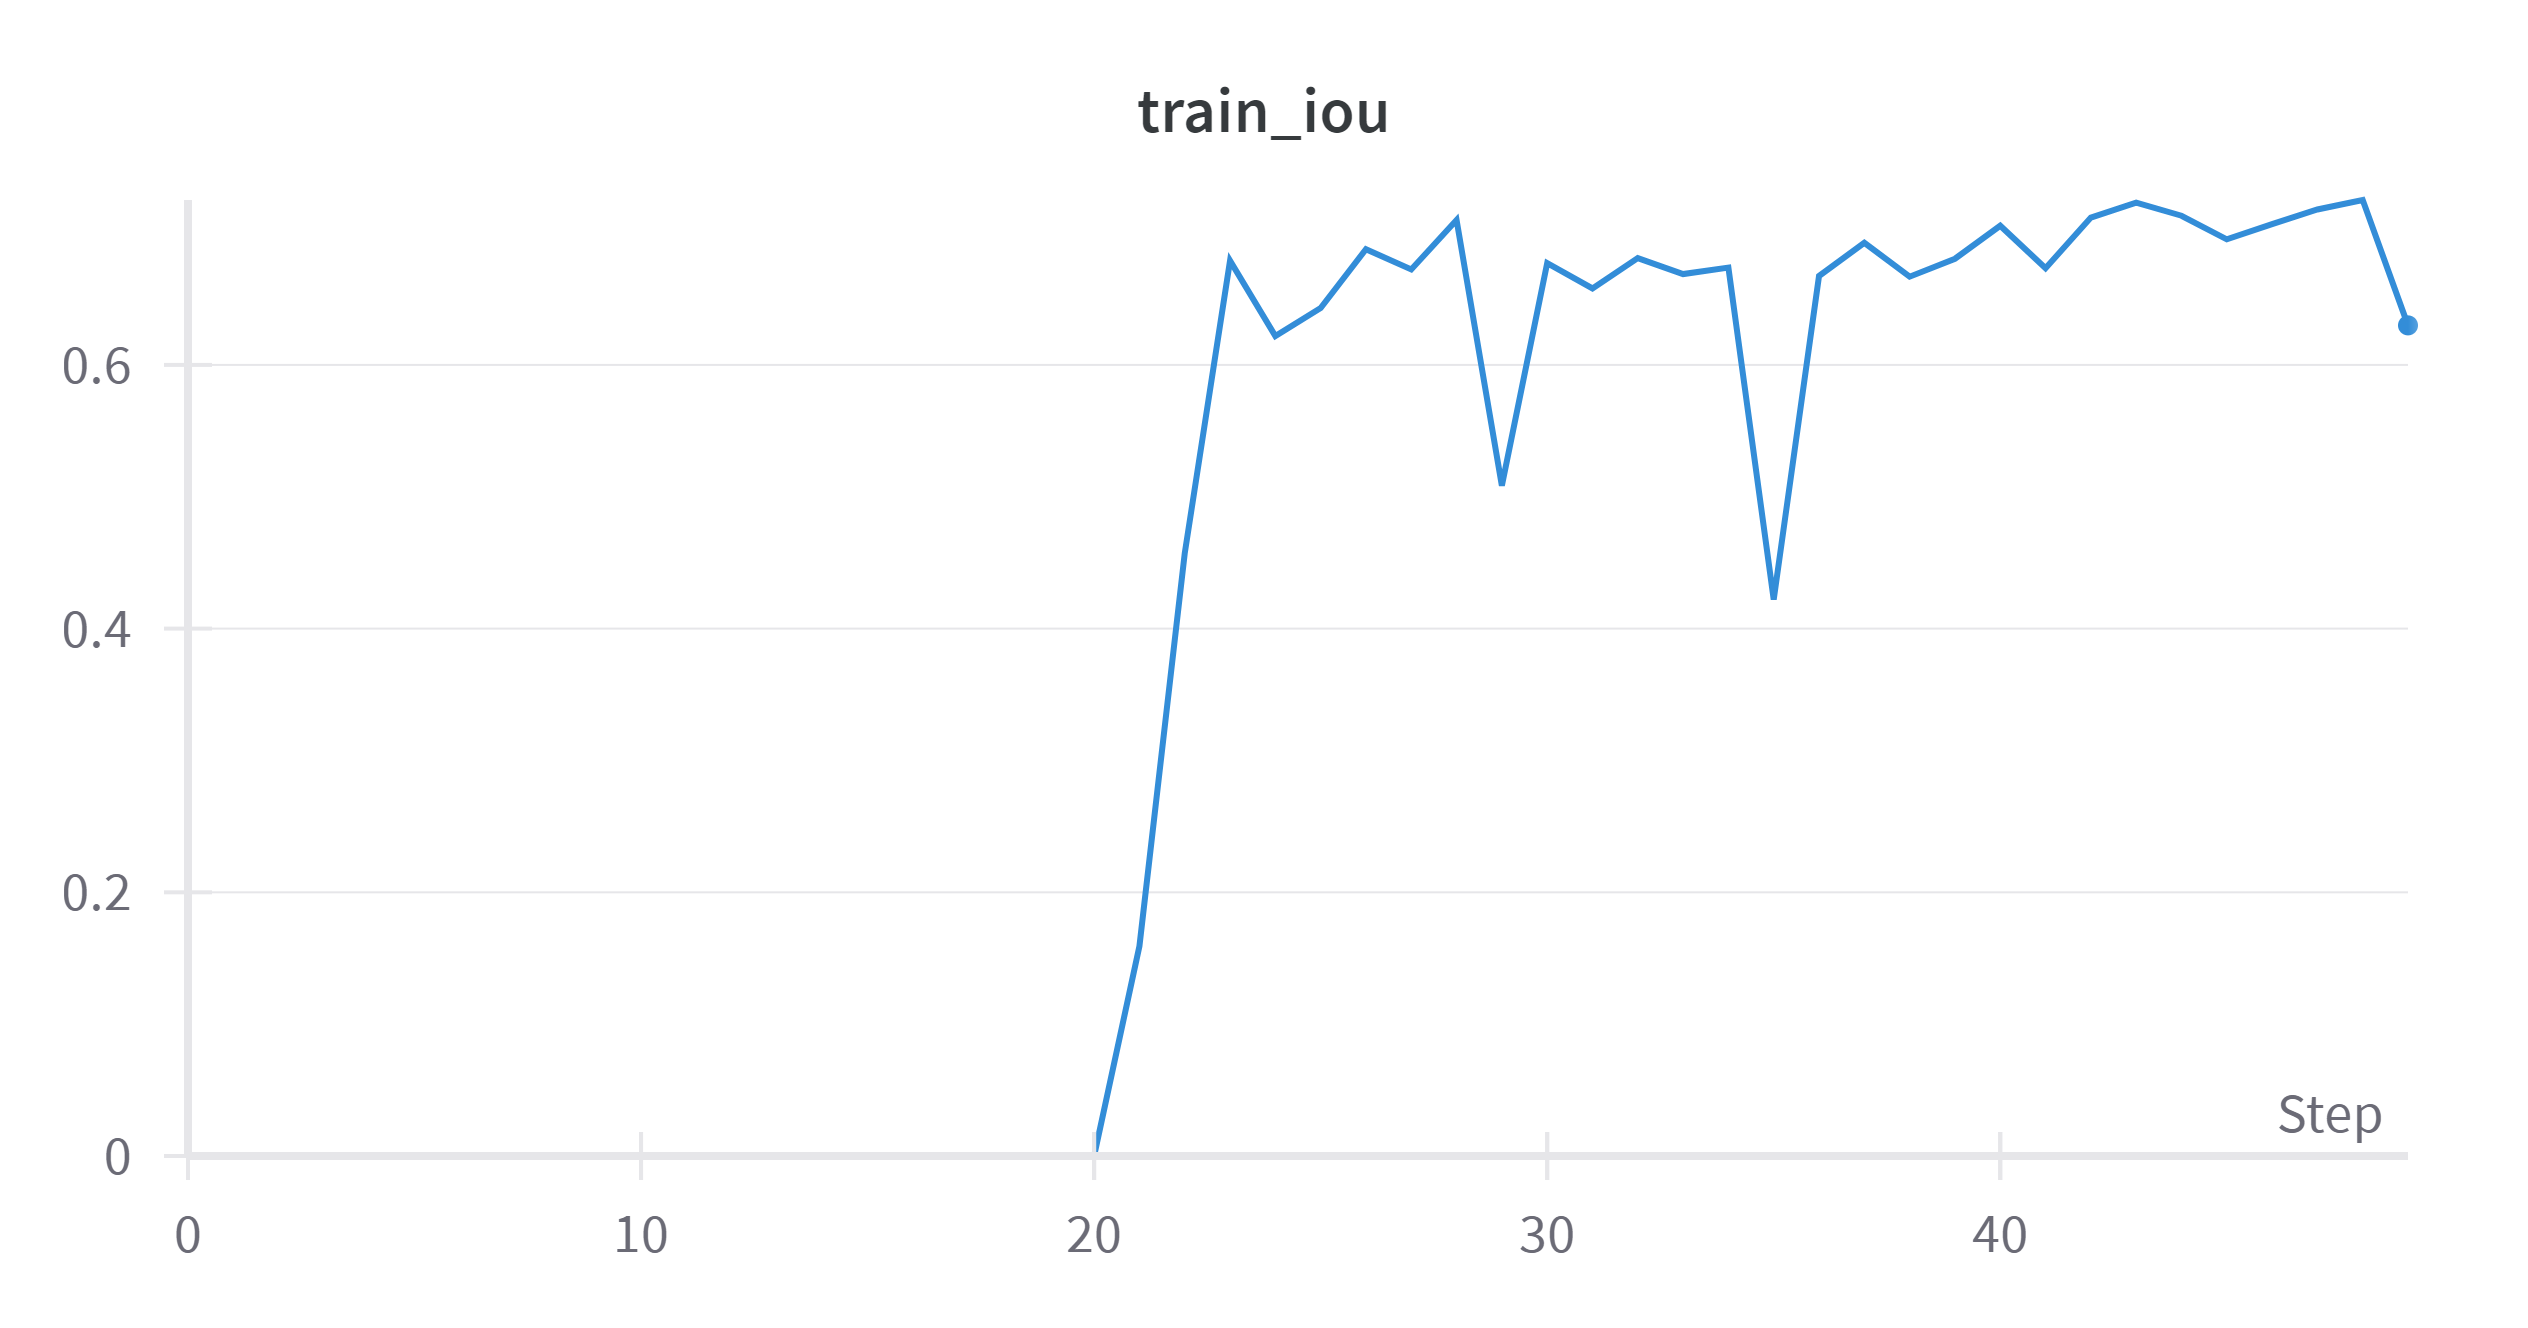

In [ ]:
# Test the model
test_model(model_1, "U-Net Conv-Transpose",test_loader, device)

Test Results for U-Net Conv-Transpose:
Accuracy: 0.9510, Precision: 0.9949, Recall: 0.8127, F1-Score: 0.8946, IoU: 0.8093



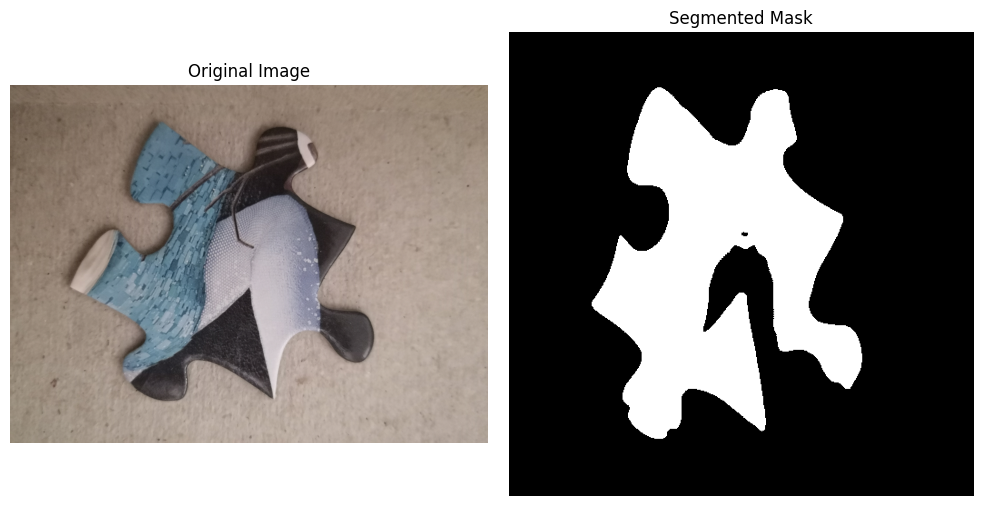

In [ ]:
# Load trained model and perform segementaion
segment_image(image_path, model_1, device)

### Comment on Overfitting:
Both our models (Conv-Transpose and Upsample) do not appear to be overfitting, because both the training and validation losses decrease consistently without significant divergence, and the validation IoU improves and stabilizes over time, indicating that the model is learning and generalizing well without overfitting to the training data.

TRAINING UNET AND DEEPLAB VARIANTS USING SEGMENTATION MODELS

U-Net and DeepLab v3+ Models

In [ ]:
# Function to create U-Net and DeepLab v3+ models
def create_model(model_type, backbone):
    if model_type == 'unet':
        return smp.Unet(encoder_name=backbone, encoder_weights='imagenet', in_channels=3, classes=2, activation=None)
    elif model_type == 'deeplabv3plus':
        return smp.DeepLabV3Plus(encoder_name=backbone, encoder_weights='imagenet', in_channels=3, classes=2, activation=None)

# Function to calculate IoU
def compute_iou(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(2, 3))  # Sum across H and W
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) - intersection
    iou = (intersection / union).mean()  # Mean IoU across the batch
    return iou

# Function to calculate accuracy
def compute_accuracy(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    correct = (preds == targets).float().sum()
    total = torch.numel(preds)
    return correct / total

# Sample training loop with checkpointing and metrics
def train_model(model, dataloader_train, dataloader_val, optimizer, criterion, num_epochs, device):
    best_loss = float('inf')
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_accuracy = 0.0
        train_iou = 0.0

        # Training loop
        for inputs, masks in dataloader_train:
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            binary_mask = probabilities[:, 1, :, :].unsqueeze(1)  # Get the foreground probabilities
            loss = criterion(binary_mask, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Compute accuracy and IoU for the current batch
            train_accuracy += compute_accuracy(binary_mask, masks)
            train_iou += compute_iou(binary_mask, masks)

        train_loss /= len(dataloader_train)
        train_accuracy /= len(dataloader_train)
        train_iou /= len(dataloader_train)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        val_iou = 0.0
        with torch.no_grad():
            for inputs, masks in dataloader_val:
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs)
                probabilities = F.softmax(outputs, dim=1)
                binary_mask = probabilities[:, 1, :, :].unsqueeze(1)
                loss = criterion(binary_mask, masks)
                val_loss += loss.item()

                # Compute accuracy and IoU for the validation batch
                val_accuracy += compute_accuracy(binary_mask, masks)
                val_iou += compute_iou(binary_mask, masks)

        val_loss /= len(dataloader_val)
        val_accuracy /= len(dataloader_val)
        val_iou /= len(dataloader_val)

        # Checkpoint
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = model.state_dict()

        # Print the metrics
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, '
              f'Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}')

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model

A U-Net with ResNet34 backbone

In [ ]:
# A U-Net with ResNet34 backbone
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model('unet', 'resnet34').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

# Replace train_loader and val_loader with actual data loaders
trained_model_unet_resnet34 = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=20, device=device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 36.4MB/s]


Epoch 1/20, Train Loss: 0.8047, Val Loss: 1.0434, Train Accuracy: 0.7085, Val Accuracy: 0.2476, Train IoU: 0.4998, Val IoU: 0.2417
Epoch 2/20, Train Loss: 0.6845, Val Loss: 0.8888, Train Accuracy: 0.9426, Val Accuracy: 0.5721, Train IoU: 0.8074, Val IoU: 0.3577
Epoch 3/20, Train Loss: 0.6576, Val Loss: 0.7528, Train Accuracy: 0.9601, Val Accuracy: 0.7957, Train IoU: 0.8604, Val IoU: 0.5295
Epoch 4/20, Train Loss: 0.6439, Val Loss: 0.6664, Train Accuracy: 0.9722, Val Accuracy: 0.9132, Train IoU: 0.8988, Val IoU: 0.6597
Epoch 5/20, Train Loss: 0.6342, Val Loss: 0.6384, Train Accuracy: 0.9787, Val Accuracy: 0.9704, Train IoU: 0.9196, Val IoU: 0.8827
Epoch 6/20, Train Loss: 0.6265, Val Loss: 0.6331, Train Accuracy: 0.9860, Val Accuracy: 0.9724, Train IoU: 0.9449, Val IoU: 0.8886
Epoch 7/20, Train Loss: 0.6210, Val Loss: 0.6265, Train Accuracy: 0.9899, Val Accuracy: 0.9796, Train IoU: 0.9598, Val IoU: 0.9169
Epoch 8/20, Train Loss: 0.6176, Val Loss: 0.6215, Train Accuracy: 0.9901, Val Accur

Reducing the learning rate helped a bit

A U-Net with 'efficientnet-b0' backbone

In [ ]:
# A U-Net with 'efficientnet-b0' backbone
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model('unet', 'efficientnet-b0').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss()

# Replace train_loader and val_loader with actual data loaders
trained_model_unet_efficientnet_b0 = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=20, device=device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 207MB/s]


Epoch 1/20, Train Loss: 0.8217, Val Loss: 0.7582, Train Accuracy: 0.6369, Val Accuracy: 0.7527, Train IoU: 0.2112, Val IoU: 0.0041
Epoch 2/20, Train Loss: 0.7841, Val Loss: 0.7842, Train Accuracy: 0.7885, Val Accuracy: 0.7608, Train IoU: 0.3993, Val IoU: 0.0111
Epoch 3/20, Train Loss: 0.7582, Val Loss: 0.7985, Train Accuracy: 0.8624, Val Accuracy: 0.7612, Train IoU: 0.5428, Val IoU: 0.0133
Epoch 4/20, Train Loss: 0.7395, Val Loss: 0.7981, Train Accuracy: 0.9041, Val Accuracy: 0.7609, Train IoU: 0.6479, Val IoU: 0.0145
Epoch 5/20, Train Loss: 0.7262, Val Loss: 0.8001, Train Accuracy: 0.9200, Val Accuracy: 0.7702, Train IoU: 0.6985, Val IoU: 0.0671
Epoch 6/20, Train Loss: 0.7170, Val Loss: 0.8268, Train Accuracy: 0.9367, Val Accuracy: 0.6180, Train IoU: 0.7611, Val IoU: 0.0902
Epoch 7/20, Train Loss: 0.7044, Val Loss: 0.8587, Train Accuracy: 0.9556, Val Accuracy: 0.4153, Train IoU: 0.8293, Val IoU: 0.0971
Epoch 8/20, Train Loss: 0.6972, Val Loss: 0.8946, Train Accuracy: 0.9591, Val Accur

A U-Net with 'mobilenet_v2' backbone

In [ ]:
#  A U-Net with 'mobilenet_v2' backbone
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model('unet', 'mobilenet_v2').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

# Replace train_loader and val_loader with actual data loaders
trained_model_unet_mobilenet_v2 = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=20, device=device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 10.7MB/s]


Epoch 1/20, Train Loss: 0.7382, Val Loss: 0.9496, Train Accuracy: 0.7960, Val Accuracy: 0.3655, Train IoU: 0.4102, Val IoU: 0.2762
Epoch 2/20, Train Loss: 0.6550, Val Loss: 0.7168, Train Accuracy: 0.9371, Val Accuracy: 0.8297, Train IoU: 0.7711, Val IoU: 0.5761
Epoch 3/20, Train Loss: 0.6300, Val Loss: 0.7854, Train Accuracy: 0.9666, Val Accuracy: 0.6896, Train IoU: 0.8727, Val IoU: 0.4431
Epoch 4/20, Train Loss: 0.6184, Val Loss: 0.7580, Train Accuracy: 0.9791, Val Accuracy: 0.7416, Train IoU: 0.9188, Val IoU: 0.4883
Epoch 5/20, Train Loss: 0.6132, Val Loss: 0.6750, Train Accuracy: 0.9832, Val Accuracy: 0.8786, Train IoU: 0.9338, Val IoU: 0.6682
Epoch 6/20, Train Loss: 0.6094, Val Loss: 0.6182, Train Accuracy: 0.9862, Val Accuracy: 0.9753, Train IoU: 0.9453, Val IoU: 0.9036
Epoch 7/20, Train Loss: 0.6074, Val Loss: 0.6120, Train Accuracy: 0.9894, Val Accuracy: 0.9859, Train IoU: 0.9577, Val IoU: 0.9432
Epoch 8/20, Train Loss: 0.6061, Val Loss: 0.6111, Train Accuracy: 0.9888, Val Accur

A DeepLabv3+ with ResNet50 backbone

In [ ]:
# a DeepLabv3+ with ResNet50 backbone
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model('deeplabv3plus', 'resnet50').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

# Replace train_loader and val_loader with actual data loaders
trained_model_dp_resnet50 = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=20, device=device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 238MB/s]


Epoch 1/20, Train Loss: 0.7268, Val Loss: 0.8479, Train Accuracy: 0.8424, Val Accuracy: 0.7397, Train IoU: 0.5608, Val IoU: 0.4649
Epoch 2/20, Train Loss: 0.6422, Val Loss: 0.8964, Train Accuracy: 0.9390, Val Accuracy: 0.3617, Train IoU: 0.7825, Val IoU: 0.2737
Epoch 3/20, Train Loss: 0.6204, Val Loss: 0.9603, Train Accuracy: 0.9707, Val Accuracy: 0.2594, Train IoU: 0.8868, Val IoU: 0.2443
Epoch 4/20, Train Loss: 0.6145, Val Loss: 0.6671, Train Accuracy: 0.9796, Val Accuracy: 0.9488, Train IoU: 0.9210, Val IoU: 0.8059
Epoch 5/20, Train Loss: 0.6116, Val Loss: 0.7215, Train Accuracy: 0.9824, Val Accuracy: 0.8395, Train IoU: 0.9308, Val IoU: 0.5848
Epoch 6/20, Train Loss: 0.6082, Val Loss: 0.6422, Train Accuracy: 0.9860, Val Accuracy: 0.9530, Train IoU: 0.9445, Val IoU: 0.8066
Epoch 7/20, Train Loss: 0.6064, Val Loss: 0.6250, Train Accuracy: 0.9897, Val Accuracy: 0.9765, Train IoU: 0.9589, Val IoU: 0.9052
Epoch 8/20, Train Loss: 0.6052, Val Loss: 0.6105, Train Accuracy: 0.9915, Val Accur

A DeepLabv3+ wit with xception backbone

In [ ]:
# A DeepLabv3+ wit with xception backbone
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model('deeplabv3plus',  'mobilenet_v2').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

# Replace train_loader and val_loader with actual data loaders
trained_model_dp_mobilenet_v2 = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=20, device=device)

Epoch 1/20, Train Loss: 0.7667, Val Loss: 0.8643, Train Accuracy: 0.7428, Val Accuracy: 0.2605, Train IoU: 0.5615, Val IoU: 0.2453
Epoch 2/20, Train Loss: 0.6601, Val Loss: 0.9633, Train Accuracy: 0.9170, Val Accuracy: 0.4251, Train IoU: 0.7293, Val IoU: 0.2944
Epoch 3/20, Train Loss: 0.6421, Val Loss: 0.9620, Train Accuracy: 0.9294, Val Accuracy: 0.4316, Train IoU: 0.7482, Val IoU: 0.2967
Epoch 4/20, Train Loss: 0.6292, Val Loss: 0.8636, Train Accuracy: 0.9521, Val Accuracy: 0.5929, Train IoU: 0.8246, Val IoU: 0.3751
Epoch 5/20, Train Loss: 0.6229, Val Loss: 0.7336, Train Accuracy: 0.9603, Val Accuracy: 0.7948, Train IoU: 0.8478, Val IoU: 0.5425
Epoch 6/20, Train Loss: 0.6181, Val Loss: 0.6390, Train Accuracy: 0.9688, Val Accuracy: 0.9491, Train IoU: 0.8799, Val IoU: 0.8218
Epoch 7/20, Train Loss: 0.6141, Val Loss: 0.6216, Train Accuracy: 0.9777, Val Accuracy: 0.9755, Train IoU: 0.9125, Val IoU: 0.9040
Epoch 8/20, Train Loss: 0.6114, Val Loss: 0.6194, Train Accuracy: 0.9825, Val Accur

A DeepLabv3+ with 'efficientnet-b3' backbone

In [ ]:
# A DeepLabv3+ with 'efficientnet-b3' backbone
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model('deeplabv3plus', 'efficientnet-b3').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

# Replace train_loader and val_loader with actual data loaders
trained_model_dp_efficientnet_b3 = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=20 ,device=device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 74.0MB/s]


Epoch 1/20, Train Loss: 0.7361, Val Loss: 0.8220, Train Accuracy: 0.8120, Val Accuracy: 0.9126, Train IoU: 0.5556, Val IoU: 0.7222
Epoch 2/20, Train Loss: 0.6500, Val Loss: 0.7541, Train Accuracy: 0.9237, Val Accuracy: 0.9036, Train IoU: 0.7327, Val IoU: 0.7080
Epoch 3/20, Train Loss: 0.6361, Val Loss: 0.6938, Train Accuracy: 0.9384, Val Accuracy: 0.9129, Train IoU: 0.7747, Val IoU: 0.7296
Epoch 4/20, Train Loss: 0.6269, Val Loss: 0.6490, Train Accuracy: 0.9533, Val Accuracy: 0.9487, Train IoU: 0.8246, Val IoU: 0.8124
Epoch 5/20, Train Loss: 0.6212, Val Loss: 0.6364, Train Accuracy: 0.9620, Val Accuracy: 0.9529, Train IoU: 0.8508, Val IoU: 0.8169
Epoch 6/20, Train Loss: 0.6157, Val Loss: 0.6316, Train Accuracy: 0.9723, Val Accuracy: 0.9584, Train IoU: 0.8904, Val IoU: 0.8384
Epoch 7/20, Train Loss: 0.6129, Val Loss: 0.6273, Train Accuracy: 0.9797, Val Accuracy: 0.9644, Train IoU: 0.9200, Val IoU: 0.8602
Epoch 8/20, Train Loss: 0.6099, Val Loss: 0.6248, Train Accuracy: 0.9835, Val Accur

TESTING THE MODELS

In [ ]:
# Function to load and preprocess the image
def load_image(image_path, device, img_size=(512,512)):
    from PIL import Image
    from torchvision import transforms

    # Load image using PIL
    original_img = Image.open(image_path).convert('RGB')

    # Define the preprocessing transformations
    preprocess = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),  # Converts to tensor and scales between [0, 1]
    ])

    # Apply preprocessing
    img_tensor = preprocess(original_img).unsqueeze(0).to(device)

    return img_tensor, original_img

# Function to postprocess the output
def postprocess_output(output):

    # Apply softmax to get probabilities
    probs = torch.softmax(output, dim=1)  # Shape: [batch_size, num_classes, height, width]

    # Select the foreground class probabilities
    mask = probs[0, 1].cpu().detach().numpy()

    # Apply threshold to get a binary mask
    binary_mask = mask > 0.35

    return binary_mask

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')
    plt.axis('equal')

    # Plot segmentation mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Segmented Mask")
    plt.axis('off')
    plt.axis('equal')  # Ensure equal aspect ratio

    plt.show()

# Function to segment an image
def segment_image(image_path, model, device):
    model.eval()  # Set the model to evaluation mode

    # Load and preprocess the image
    img_tensor, original_img = load_image(image_path, device)

    # Perform inference
    with torch.no_grad():
        output = model(img_tensor)

    # Postprocess the output to get the segmentation mask
    mask = postprocess_output(output)

    # Plot the original image and the segmented mask
    plot_segmentation(original_img, mask)

image_path = '/content/drive/MyDrive/Lab 3/images/test/image-16.png'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Test the model
test_model(trained_model_unet_resnet34, "U-Net Rest-Net 34", test_loader, device)

Test Results for U-Net Rest-Net 34:
Accuracy: 0.9945, Precision: 0.9970, Recall: 0.9814, F1-Score: 0.9892, IoU: 0.9785



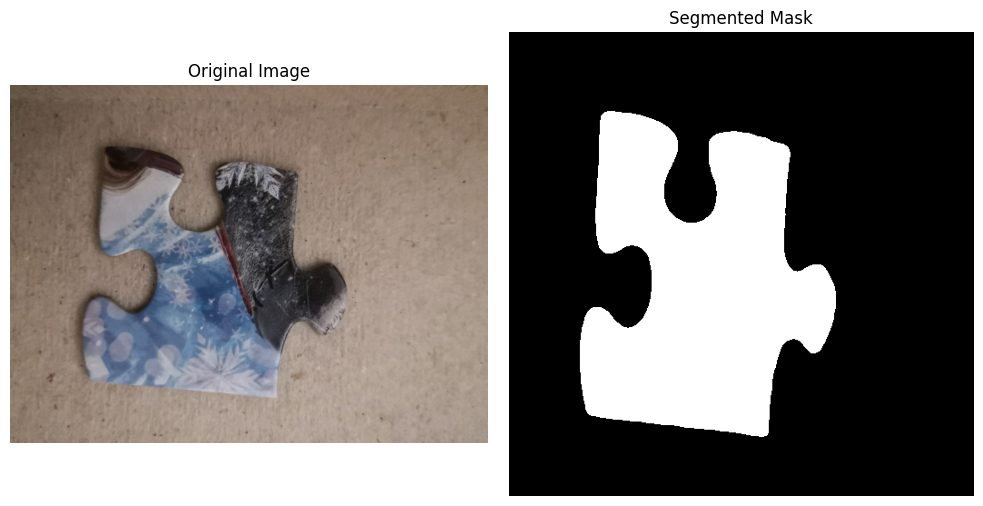

In [ ]:
segment_image(image_path, trained_model_unet_resnet34, device)

In [ ]:
# Test the model
test_model(trained_model_unet_efficientnet_b0, "U-Net Efficient-Net b0", test_loader, device)

Test Results for U-Net Efficient-Net b0:
Accuracy: 0.2154, Precision: 0.1873, Recall: 0.6194, F1-Score: 0.2876, IoU: 0.1679



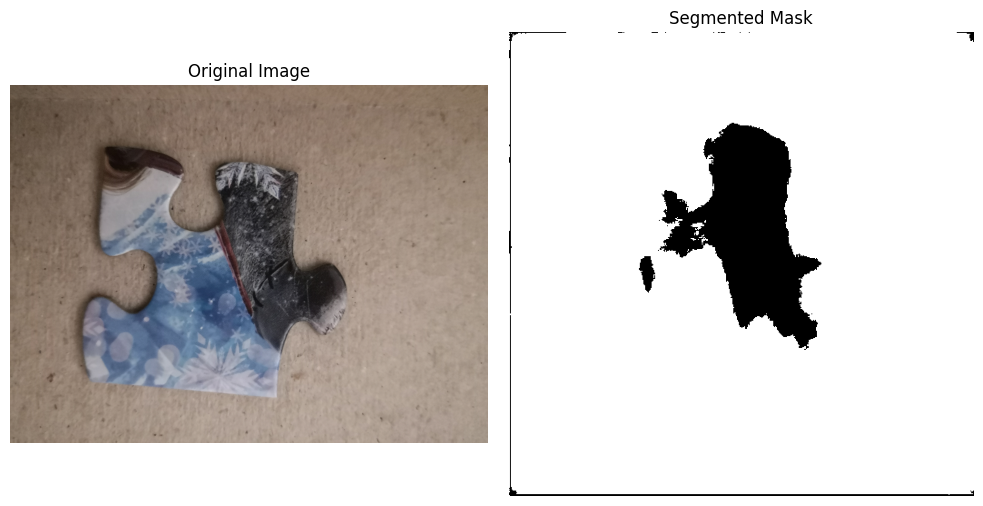

In [ ]:
segment_image(image_path, trained_model_unet_efficientnet_b0, device)

In [ ]:
# Test the model
test_model(trained_model_unet_mobilenet_v2, "U-Net Mobile-Net v2", test_loader, device)

Test Results for U-Net Mobile-Net v2:
Accuracy: 0.9956, Precision: 0.9941, Recall: 0.9886, F1-Score: 0.9913, IoU: 0.9828



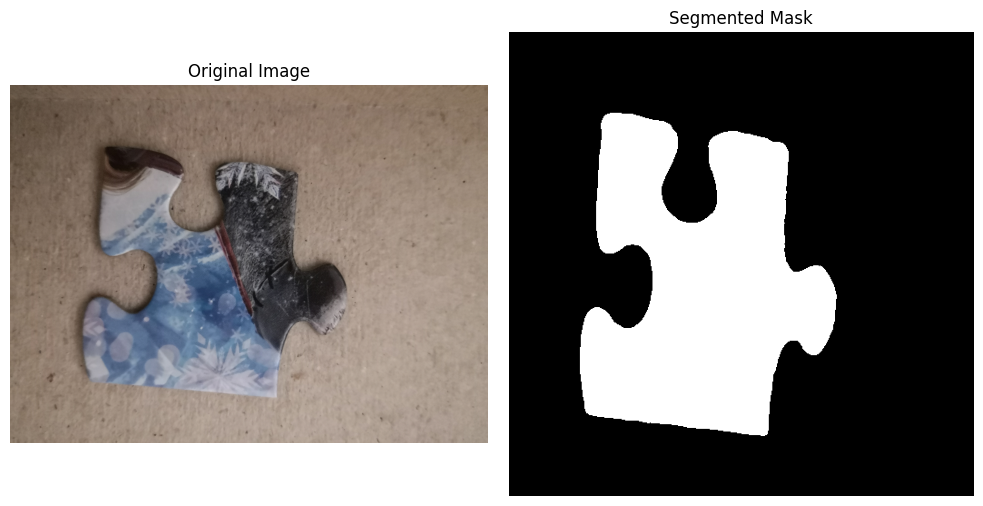

In [ ]:
segment_image(image_path, trained_model_unet_mobilenet_v2, device)

In [ ]:
# Test the model
test_model(trained_model_dp_resnet50, "DeepLab Rest-Net 50", test_loader, device)

Test Results for DeepLab Rest-Net 50:
Accuracy: 0.9948, Precision: 0.9957, Recall: 0.9839, F1-Score: 0.9898, IoU: 0.9797



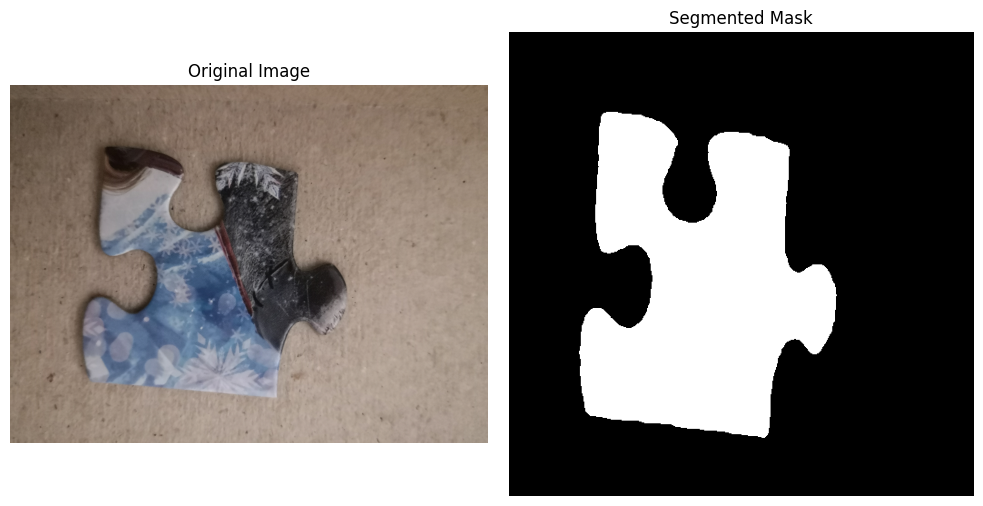

In [ ]:
segment_image(image_path, trained_model_dp_resnet50, device)

In [ ]:
# Test the model
test_model(trained_model_dp_mobilenet_v2, "DeepLab Mobile-Net v2", test_loader, device)

Test Results for DeepLab Mobile-Net v2:
Accuracy: 0.9899, Precision: 0.9947, Recall: 0.9658, F1-Score: 0.9800, IoU: 0.9609



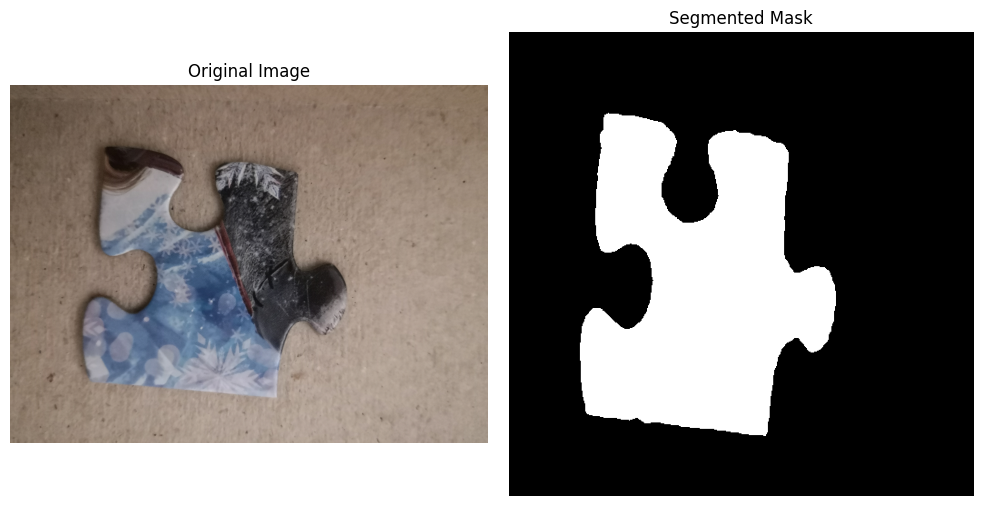

In [ ]:
segment_image(image_path, trained_model_dp_mobilenet_v2, device)

In [ ]:
# Test the model
test_model(trained_model_dp_efficientnet_b3, "DeepLab Efficient-Net b3", test_loader, device)

Test Results for DeepLab Efficient-Net b3:
Accuracy: 0.9500, Precision: 0.9929, Recall: 0.8101, F1-Score: 0.8922, IoU: 0.8054



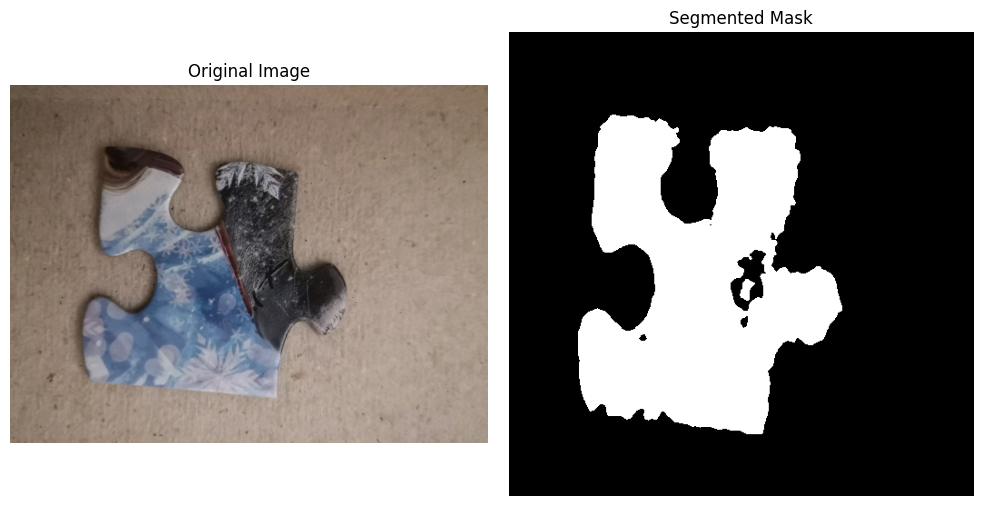

In [ ]:
segment_image(image_path, trained_model_dp_efficientnet_b3, device)

In [ ]:
print_final_metrics_table()


Final Table of Model Evaluation Metrics:
                 Model Name  Accuracy  Precision    Recall  F1 Score       IoU
0            U-Net Upsample  0.972111   0.957047  0.932779  0.944757  0.895299
1      U-Net Conv-Transpose  0.951046   0.994872  0.812713  0.894614  0.809323
2         U-Net Rest-Net 34  0.994495   0.996991  0.981431  0.989150  0.978533
3    U-Net Efficient-Net b0  0.215414   0.187263  0.619380  0.287579  0.167937
4       U-Net Mobile-Net v2  0.995585   0.994137  0.988563  0.991342  0.982833
5       DeepLab Rest-Net 50  0.994799   0.995678  0.983927  0.989768  0.979742
6     DeepLab Mobile-Net v2  0.989943   0.994740  0.965768  0.980040  0.960862
7  DeepLab Efficient-Net b3  0.949967   0.992922  0.810080  0.892230  0.805429


Best Model (Model with highest Validation IoU) is U-Net with ResNet34 backbone with Validation IoU of around 98.30% and its Test Evaluation Metrics are: Accuracy: 0.9945, Precision: 0.9970, Recall: 0.9814, F1-Score: 0.9892, IoU: 0.9785

## Discussion

### Insights on Model Performance:
Looking at the results:

1. The first two U-Net models implemented underperformed compared to some of the pre-built architectures from the Segmentation Models PyTorch library. However, there was a notable difference between the two upsampling methods: the model using ConvTranspose2d for upsampling performed less than the one using bilinear interpolation with Upsample. Additionally, the custom U-Net models took significantly longer to train, though they were better at avoiding overfitting. Both training and validation losses gradually decreased over time, indicating stable learning. In contrast, the pre-built segmentation models from PyTorch were more prone to overfitting. In the initial epochs, these models quickly improved on the training data but performed worse on the validation set, showing early signs of overfitting. After some improvement on validation data, overfitting resurfaced in later epochs. Saving model weights at the point of lowest validation loss helped mitigate this issue and preserve the model's best performance on the validation set.
    
2. All models appeared to rely heavily on similarities in color intensities to differentiate between the foreground and background. As a result, they struggled when parts of the puzzle pieces had color patterns or textures that were similar to the background. This difficulty may be attributed to a class imbalance, where the background dominates the dataset, making it harder for the models to accurately identify the foreground in challenging cases.
Reducing the probability threshold for classifying a pixel as foreground helped increasing most metrics though it also increased the number of true negatives. A threshold of 0.35 was found to balance the trade-off rather than the more usually used 0.5.

3. U-Net Rest-Net 34, U-Net Mobile-Net v2 and DeepLab Rest-Net 50 showed the highest performance across all metrics, with accuracies of over 99%, and F1 Scores of approximately 0.99. These models handle complex image features well and generalize efficiently across the test data.

4. U-Net Efficient-Net b0 significantly underperformed with only 21% accuracy and low F1 Score (0.16). This indicates potential inefficiencies in handling the given dataset.

5. Augmentation strategies (flip, rotate, color adjustments) didn't significantly boost model performance, as shown by results like U-Net Mobile-Net v2 and DeepLab Efficient-Net b3, which have very high precision but lower recall. (Jupyter Notebook we implemented with Augmentation is available on demand).

### Challenges Faced:
1. Channel Output Mismatch: The model implementation produces two-channel output, for foreground and background whilst the mask is 1 channel. This caused mismatch when training and evaluating the model.  The solution was to softmax the two channels, and then use the foreground channel whereby probabilities will be high if its foreground and probabilities will be low if its background.

2. Data Augmentation Issue: Early attempts at augmentation (horizontal/vertical flips) led to a misalignment between images and masks because the augmentation was applied only to the images, not the masks. This was resolved by creating a function that augments both images and masks simultaneously, storing them in a separate folder (augmented_check) and skipping re-augmentation if data was already present.

### Suggestions for Improvement:
1. Refining Augmentation Strategies: Although augmentations like flipping, rotation, and color transformations were applied, but they did not seem to boost performance significantly. Perhaps using more task-specific augmentations like elastic deformations, which might better mimic real-world variations in the data might help better.

2. Advanced Model Architectures: Given the strong results from ResNet-based models, may be exploring even deeper architectures or leveraging techniques like attention mechanisms might yield further improvements.

3. Hyperparameter Tuning: Although we experimented with adjusting the learning rate and observed improvements with a smaller rate, further fine-tuning of the learning rate, batch sizes, or introducing advanced regularization techniques (e.g., dropout or weight decay) could potentially improve performance and enhance generalization.